<a href="https://colab.research.google.com/github/lukekolbe/AL-in-CreditScoring/blob/main/result_processor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Prep Runtime

In [1]:
from google.colab import drive
drive.mount('/gdrive', force_remount=True)

Mounted at /gdrive


In [2]:
!pip freeze

absl-py==1.0.0
alabaster==0.7.12
albumentations==0.1.12
altair==4.2.0
appdirs==1.4.4
argon2-cffi==21.3.0
argon2-cffi-bindings==21.2.0
arviz==0.12.0
astor==0.8.1
astropy==4.3.1
astunparse==1.6.3
atari-py==0.2.9
atomicwrites==1.4.0
attrs==21.4.0
audioread==2.1.9
autograd==1.4
Babel==2.10.1
backcall==0.2.0
beautifulsoup4==4.6.3
bleach==5.0.0
blis==0.4.1
bokeh==2.3.3
Bottleneck==1.3.4
branca==0.5.0
bs4==0.0.1
CacheControl==0.12.11
cached-property==1.5.2
cachetools==4.2.4
catalogue==1.0.0
certifi==2021.10.8
cffi==1.15.0
cftime==1.6.0
chardet==3.0.4
charset-normalizer==2.0.12
click==7.1.2
cloudpickle==1.3.0
cmake==3.22.4
cmdstanpy==0.9.5
colorcet==3.0.0
colorlover==0.3.0
community==1.0.0b1
contextlib2==0.5.5
convertdate==2.4.0
coverage==3.7.1
coveralls==0.5
crcmod==1.7
cufflinks==0.17.3
cvxopt==1.2.7
cvxpy==1.0.31
cycler==0.11.0
cymem==2.0.6
Cython==0.29.28
daft==0.0.4
dask==2.12.0
datascience==0.10.6
debugpy==1.0.0
decorator==4.4.2
defusedxml==0.7.1
descartes==1.1.0
dill==0.3.4
distributed=

In [25]:
!pip uninstall matplotlib -y

Found existing installation: matplotlib 3.2.2
Uninstalling matplotlib-3.2.2:
  Successfully uninstalled matplotlib-3.2.2


In [2]:
!pip install pingouin
!pip install scikit_posthocs
!pip install matplotlib

     |████████████████████████████████| 183 kB 14.5 MB/s 
     |████████████████████████████████| 38.1 MB 1.2 MB/s 
     |████████████████████████████████| 9.8 MB 45.8 MB/s 
  Created wheel for pingouin: filename=pingouin-0.5.1-py3-none-any.whl size=194002 sha256=46aed2123049e7e866ad7e2fe793e041abb2c075264736486490ab26cd2117bc
  Stored in directory: /root/.cache/pip/wheels/74/a7/b6/5b5f03b0395fdada1f45d3aed76e7da48873a02805545ef652
  Created wheel for littleutils: filename=littleutils-0.2.2-py3-none-any.whl size=7048 sha256=435f6874c03f9d2aef8493cd79df9e5a011cfa3f9beb457fc1c7c6e8090b10fc
  Stored in directory: /root/.cache/pip/wheels/d6/64/cd/32819b511a488e4993f2fab909a95330289c3f4e0f6ef4676d
Successfully built pingouin littleutils
  Attempting uninstall: scipy
    Found existing installation: scipy 1.4.1
    Uninstalling scipy-1.4.1:
      Successfully uninstalled scipy-1.4.1
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.10.2
    Uninstalling stats

In [3]:
############ LIBRARIES

import os
import time
import datetime
import random
import pickle
import re
import copy
import gc
import sys
import json

gc.enable()

import warnings
warnings.filterwarnings('ignore')

import pingouin as pg
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)

import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
plt.style.use('default')
%matplotlib inline
import seaborn as sns

import scipy.stats
from collections import namedtuple
import scikit_posthocs as sp

In [4]:
os.chdir('/gdrive/My Drive/ACTIVE LEARNING THESIS/')

# Helper Functions

In [5]:
from collections import namedtuple

'''
  This function is an enhanced version of the Friedman Test found in the popular scipy package.
  The added functionality computes z-values (pivotal quantities) that are needed to run the Holm-Test, i.e.
  pairwise comparisons of each model to the control model, with p-value adjustment.
  The formula for the z-statistic can be found in DEMSAR (2006).
'''

FriedmanchisquareResult = namedtuple('FriedmanchisquareResult',
                                     ('statistic', 'pvalue'))

def friedmanchisquare2(*args):
    """Compute the Friedman test for repeated measurements.
    The Friedman test tests the null hypothesis that repeated measurements of
    the same individuals have the same distribution.  It is often used
    to test for consistency among measurements obtained in different ways.
    For example, if two measurement techniques are used on the same set of
    individuals, the Friedman test can be used to determine if the two
    measurement techniques are consistent.
    Parameters
    ----------
    measurements1, measurements2, measurements3... : array_like
        Arrays of measurements.  All of the arrays must have the same number
        of elements.  At least 3 sets of measurements must be given.
    Returns
    -------
    statistic : float
        The test statistic, correcting for ties.
    pvalue : float
        The associated p-value assuming that the test statistic has a chi
        squared distribution.
    
    Notes
    -----
    Due to the assumption that the test statistic has a chi squared
    distribution, the p-value is only reliable for n > 10 and more than
    6 repeated measurements.
    References
    ----------
    .. [1] https://en.wikipedia.org/wiki/Friedman_test
    """

    k = len(args)
    if k < 3:
        raise ValueError('At least 3 sets of measurements must be given '
                         'for Friedman test, got {}.'.format(k))

    n = len(args[0])
    for i in range(1, k):
        if len(args[i]) != n:
            raise ValueError('Unequal N in friedmanchisquare.  Aborting.')

    # Rank data
    data = np.vstack(args).T
    data = data.astype(float)
    for i in range(len(data)):
        data[i] = scipy.stats.rankdata(data[i])

    # Handle ties
    ties = 0
    for d in data:
        replist, repnum = scipy.stats.find_repeats(np.array(d))
        for t in repnum:
            ties += t * (t*t - 1)
    c = 1 - ties / (k*(k*k - 1)*n)
    

    ssbn = np.sum(data.sum(axis=0)**2)
    chisq = (12.0 / (k*n*(k+1)) * ssbn - 3*n*(k+1)) / c #test statistic
    pvalue = scipy.stats.distributions.chi2.sf(chisq, k - 1) #p-value

    ########## ADDED CUSTOM FUNCTIONALITY TO RUN HOLM TEST ##########
    #print('data from function', data)
    rankings_avg = [np.mean([case[j] for case in data]) for j in range(k)]
    rankings_cmp = [r/np.sqrt(k*(k+1)/(6.*n)) for r in rankings_avg] #test statistics (z-value) for each method (DEMSAR 2006)
    ##########

    return chisq, pvalue, data, rankings_avg, rankings_cmp

In [6]:
# ALTERNATIVE VERSION OF FRIEDMAN TEST
# APPLIES IMAN-DAVENPORT CORRECTION TO P-VALUES

def friedman_test(*args):

    """
        Performs a Friedman ranking test.
        Tests the hypothesis that in a set of k dependent samples groups (where k >= 2) at least two of the groups represent populations with different median values.
        
        Parameters
        ----------
        sample1, sample2, ... : array_like
            The sample measurements for each group.
            
        Returns
        -------
        F-value : float
            The computed F-value of the test.
        p-value : float
            The associated p-value from the F-distribution.
        rankings : array_like
            The ranking for each group.
        pivots : array_like
            The pivotal quantities for each group.
            
        References
        ----------
        M. Friedman, The use of ranks to avoid the assumption of normality implicit in the analysis of variance, Journal of the American Statistical Association 32 (1937) 674–701.
        D.J. Sheskin, Handbook of parametric and nonparametric statistical procedures. crc Press, 2003, Test 25: The Friedman Two-Way Analysis of Variance by Ranks
    """

    k = len(args)
    if k < 2: raise ValueError('Less than 2 levels')
    n = len(args[0])
    if len(set([len(v) for v in args])) != 1: raise ValueError('Unequal number of samples')

    rankings = []
    for i in range(n):
        row = [col[i] for col in args]
        row_sort = sorted(row)
        rankings.append([row_sort.index(v) + 1 + (row_sort.count(v)-1)/2. for v in row])

    rankings_avg = [np.mean([case[j] for case in rankings]) for j in range(k)]
    rankings_cmp = [r/np.sqrt(k*(k+1)/(6.*n)) for r in rankings_avg] #see demsar (2006)

    chi2 = ((12*n)/float((k*(k+1))))*((sum(r**2 for r in rankings_avg))-((k*(k+1)**2)/float(4))) #(uncorrected) chi-square test statistic
    iman_davenport = ((n-1)*chi2)/float((n*(k-1)-chi2)) #corrected test-statistic

    p_value = 1 - scipy.stats.f.cdf(iman_davenport, k-1, (k-1)*(n-1)) #iman-davenport corrected p-value
    
    ###########
    p_value_uncorrected = scipy.stats.distributions.chi2.sf(chi2, k - 1)
    ###########

    return iman_davenport,p_value,chi2, p_value_uncorrected, rankings, rankings_avg, rankings_cmp

In [7]:
import itertools as it

def holm_test(ranks, control=None):
    """
        Performs a Holm post-hoc test using the pivot quantities obtained by a ranking test.
        Tests the hypothesis that the ranking of the control method is different to each of the other methods.
        
        Parameters
        ----------
        pivots : dictionary_like
            A dictionary with format 'groupname':'pivotal quantity' 
        control : string optional
            The name of the control method (one vs all), default None (all vs all) 
            
        Returns
        ----------
        Comparions : array-like
            Strings identifier of each comparison with format 'group_i vs group_j'
        Z-values : array-like
            The computed Z-value statistic for each comparison.
        p-values : array-like
            The associated p-value from the Z-distribution wich depends on the index of the comparison
        Adjusted p-values : array-like
            The associated adjusted p-values wich can be compared with a significance level
            
        References
        ----------
        O.J. S. Holm, A simple sequentially rejective multiple test procedure, Scandinavian Journal of Statistics 6 (1979) 65–70.
    """
    k = len(ranks.keys())
    values = list(ranks.values())
    keys = list(ranks.keys())
    if not control :
        control_i = values.index(min(values))
    else:
        control_i = keys.index(control)

    comparisons = [keys[control_i] + " vs " + keys[i] for i in range(k) if i != control_i]
    z_values = [abs(values[control_i] - values[i]) for i in range(k) if i != control_i]
    p_values = [2*(1-scipy.stats.norm.cdf(abs(z))) for z in z_values]
    
    # Sort values by p_value so that p_0 < p_1
    p_values, z_values, comparisons = map(list, zip(*sorted(zip(p_values, z_values, comparisons), key=lambda t: t[0])))
    adj_p_values = [min(max((k-(j+1))*p_values[j] for j in range(i+1)), 1) for i in range(k-1)]
    
    return comparisons, z_values, p_values, adj_p_values

In [8]:
def finner_test(ranks, control=None):
    """
        Performs a Finner post-hoc test using the pivot quantities obtained by a ranking test.
        Tests the hypothesis that the ranking of the control method is different to each of the other methods.
        
        Parameters
        ----------
        pivots : dictionary_like
            A dictionary with format 'groupname':'pivotal quantity' 
        control : string optional
            The name of the control method,  default the group with minimum ranking
            
        Returns
        ----------
        Comparions : array-like
            Strings identifier of each comparison with format 'group_i vs group_j'
        Z-values : array-like
            The computed Z-value statistic for each comparison.
        p-values : array-like
            The associated p-value from the Z-distribution wich depends on the index of the comparison
        Adjusted p-values : array-like
            The associated adjusted p-values wich can be compared with a significance level
            
        References
        ----------
        H. Finner, On a monotonicity problem in step-down multiple test procedures, Journal of the American Statistical Association 88 (1993) 920–923.
    """
    
    k = len(ranks)
    values = list(ranks.values())
    keys = list(ranks.keys())
    if not control :
        control_i = values.index(min(values))
    else:
        control_i = keys.index(control)

    comparisons = [keys[control_i] + " vs " + keys[i] for i in range(k) if i != control_i]
    z_values = [abs(values[control_i] - values[i]) for i in range(k) if i != control_i]
    p_values = [2*(1-scipy.stats.norm.cdf(abs(z))) for z in z_values]
    # Sort values by p_value so that p_0 < p_1
    p_values, z_values, comparisons = map(list, zip(*sorted(zip(p_values, z_values, comparisons), key=lambda t: t[0])))
    adj_p_values = [min(max(1-(1-p_values[j])**((k-1)/float(j+1)) for j in range(i+1)), 1) for i in range(k-1)]
    
    return comparisons, z_values, p_values, adj_p_values

In [9]:
# Helper functions for performing the statistical tests
def generate_scores(method, method_args, data, labels):
    pairwise_scores = method(data, **method_args) # Matrix for all pairwise comaprisons
    pairwise_scores.set_axis(labels, axis='columns', inplace=True) # Label the cols
    pairwise_scores.set_axis(labels, axis='rows', inplace=True) # Label the rows, note: same label as pairwise combinations
    return pairwise_scores

def pairwise_plotter(scores):
    # Pretty plot of significance
    heatmap_args = {'linewidths': 0.25, 'linecolor': '0.5', 'square': True,
                    'cbar_ax_bbox': [0.80, 0.35, 0.04, 0.3]}

    sp.sign_plot(scores, **heatmap_args)

# SCORE PERFORMANCE

## Load results as saved during computation

### SCORE METRICS

In [10]:
#load result files as specified, store in one large dictionary
dataset_list = ["bene2", "bene1_nobins","gmsc", "uk", "lendingclub", "hmeq", "australian", "german", "thomas", "pakdd"]
ratios_list = [0.1,0.2,0.3,0.4,0.5] #,0.2,0.3,0.4,0.5
cost_mat_list = [None]
weights_list = ['wF', 'wT']
results_dict = {'wT': {}, 'wF': {}} #load results for parameter weights True/False separately

for w in weights_list:
  for d in dataset_list:
    results_dict[w][d] = {}
    for r in ratios_list:
      for c in cost_mat_list:
        if w == 'wT':
          filename = f"{d}__rounds-5_max_gens-10_AL_acc_rate-{r}_weights-True_cost_matrix-{c}_do_thres-tuned"
        else:
          filename = f"{d}__rounds-5_max_gens-10_AL_acc_rate-{r}_weights-False_cost_matrix-{c}_do_thres-tuned"
          
        filename = filename.replace('.', '-')
        filename = filename.replace('[', '')
        filename = filename.replace(']', '')
        filename = filename.replace(',', '-')
        filename = filename.replace(' ', '')

        infile = open(f'model_results/{d}/{filename}','rb')

        rname = f'r{r}'.replace('.', '')

        results_dict[w][d][rname] = pickle.load(infile)

        infile.close()
        #if fname not in configs_list:
        #  configs_list.append(fname)

#print(configs_list)

In [11]:
results_dict['wT']['german']['r03']['random']['average']

,generation,n_accepts,n_rejects,bad_ratio_accepts,bad_ratio_rejects,n_score_accepts,n_AL_selects,bad_ratio_score_accepts,bad_ratio_AL_selects,roc_auc,brier,h-measure,average_precision,balanced_accuracy,pcc,precision,recall,f1,fpr,fnr,tn,fp,fn,tp
0,0.0,NaN,NaN,0.31390,0.29726,NaN,NaN,NaN,NaN,0.718548,0.186734,0.235111,0.551541,0.657857,0.561190,0.423818,0.780000,0.544556,0.464286,0.220000,75.0,65.0,13.2,46.8
1,1.0,102.2,33.8,0.28016,0.39282,21.4,8.8,0.11800,0.32980,0.736833,0.179926,0.255908,0.553345,0.651905,0.596842,0.433046,0.696667,0.532328,0.392857,0.303333,85.0,55.0,18.2,41.8
2,2.0,136.2,63.8,0.26532,0.38474,45.4,18.8,0.13390,0.36706,0.753190,0.176822,0.276318,0.573296,0.681429,0.641480,0.463195,0.730000,0.565582,0.367143,0.270000,88.6,51.4,16.2,43.8
3,3.0,163.0,101.0,0.25864,0.37306,64.2,26.8,0.13640,0.38922,0.767762,0.172338,0.291233,0.585662,0.700476,0.678746,0.486334,0.736667,0.584764,0.335714,0.263333,93.0,47.0,15.8,44.2
4,4.0,195.2,132.8,0.24796,0.38124,87.0,36.2,0.13820,0.37174,0.770619,0.172547,0.306778,0.584552,0.708333,0.697865,0.502040,0.736667,0.594522,0.320000,0.263333,95.2,44.8,15.8,44.2
5,5.0,230.2,161.8,0.24842,0.37768,111.6,46.6,0.13722,0.40636,0.773524,0.170928,0.301953,0.598835,0.707619,0.689212,0.494980,0.746667,0.592997,0.331429,0.253333,93.6,46.4,15.2,44.8
6,6.0,264.2,191.8,0.23982,0.38544,135.4,56.8,0.12690,0.40934,0.773738,0.169089,0.305435,0.598246,0.701905,0.689057,0.494044,0.726667,0.585633,0.322857,0.273333,94.8,45.2,16.4,43.6
7,7.0,297.0,223.0,0.23534,0.38696,158.4,66.6,0.12572,0.40662,0.776357,0.168153,0.311222,0.609657,0.700952,0.688286,0.494288,0.723333,0.584577,0.321429,0.276667,95.0,45.0,16.6,43.4
8,8.0,331.6,252.4,0.23492,0.38556,182.8,76.8,0.12790,0.41190,0.785500,0.164459,0.327669,0.621810,0.724048,0.720286,0.514330,0.756667,0.611526,0.308571,0.243333,96.8,43.2,14.6,45.4
9,9.0,363.8,284.2,0.23242,0.38490,205.4,86.4,0.12502,0.41680,0.790976,0.162790,0.334411,0.622082,0.726905,0.720125,0.513408,0.766667,0.614512,0.312857,0.233333,96.2,43.8,14.0,46.0


### COST METRICS

In [12]:
#load result files as specified, store in one large dictionary
dataset_list = ["bene2", "bene1_nobins","gmsc", "uk", "lendingclub", "hmeq", "australian", "german", "thomas", "pakdd"]
#dataset_list = ["bene2", "bene1_nobins","gmsc", "uk", "lendingclub", "hmeq", "australian", "german", "thomas"]
#ratios_list = [0.1,0.2,0.3,0.4,0.5] #,0.2,0.3,0.4,0.5
#cost_mat_list = [None,[[0,1],[2,0]],[[0,1],[5,0]],[[0,1],[10,0]]]
#cost_mat_list = [None]
#weights_list = ['wF', 'wT']
cost_dict = {'wT': {}, 'wF': {}} #load results for parameter weights True/False separately
#configs_list = []

for w in weights_list:
  for d in dataset_list:
    cost_dict[w][d] = {}
    for r in ratios_list:
      for c in cost_mat_list:
        if w == 'wT':
          filename = f"{d}__rounds-5_max_gens-10_AL_acc_rate-{r}_weights-True_cost_matrix-{c}_do_thres-tuned"
        else:
          filename = f"{d}__rounds-5_max_gens-10_AL_acc_rate-{r}_weights-False_cost_matrix-{c}_do_thres-tuned"
          
        filename = filename.replace('.', '-')
        filename = filename.replace('[', '')
        filename = filename.replace(']', '')
        filename = filename.replace(',', '-')
        filename = filename.replace(' ', '')

        infile = open(f'model_cost/{d}/{filename}','rb')

        rname = f'r{r}'.replace('.', '')

        cost_dict[w][d][rname] = pickle.load(infile)

        infile.close()
        #if fname not in configs_list:
        #  configs_list.append(fname)

#print(configs_list)

In [13]:
cost_dict['wT']['pakdd']['r03']['random']['average']

,generation,gen_internal_cost,gen_internal_cpl,total_internal_cost,total_internal_cpl,model_internal_cost,model_internal_cpl,external_cost,external_cpl
0,0.0,351.423664,0.702847,351.423664,0.702847,0.000000,NaN,6735.233019,0.673523
1,1.0,351.641086,0.703282,703.064750,0.703065,351.641086,0.703282,6591.518565,0.659152
2,2.0,347.004402,0.694009,1050.069151,0.700046,698.645487,0.698645,6484.031209,0.648403
3,3.0,342.138026,0.684276,1392.207177,0.696104,1040.783514,0.693856,6498.143011,0.649814
4,4.0,345.740649,0.691481,1737.947826,0.695179,1386.524162,0.693262,6442.019845,0.644202
5,5.0,345.604402,0.691209,2083.552228,0.694517,1732.128564,0.692851,6424.073108,0.642407
6,6.0,326.667280,0.653335,2410.219508,0.688634,2058.795844,0.686265,6334.162181,0.633416
7,7.0,336.303090,0.672606,2746.522598,0.686631,2395.098934,0.684314,6545.979572,0.654598
8,8.0,346.431470,0.692863,3092.954068,0.687323,2741.530404,0.685383,6480.759528,0.648076
9,9.0,342.301342,0.684603,3435.255410,0.687051,3083.831746,0.685296,6313.246883,0.631325


### Build table template to fill with aggregated results

In [53]:
# ALT: EVERY PARAMETER COMBINATION AS OWN CLASSIFER
#model_list = ['oracle','score', 'random', 'unc', 'qbc', 'dw', 'cors', 'density', 'eer', 'lal', 'quire', 'bmdr', 'spal']
model_list = ['score', 'random', 'unc', 'qbc', 'dw', 'cors', 'density', 'eer', 'lal', 'quire', 'bmdr', 'spal']
metrics_list = ['roc_auc', 'brier', 'h-measure', 'pcc', 'balanced_accuracy', 'f1']
cost_metrics = ['total_internal_cost','total_internal_cpl','external_cost','external_cpl']

# built list of column names
c_names = model_list
#for i in 
column_names = ['score']
index_names = []

for m in model_list:
  for w in weights_list:
    for r in ["r01","r02","r03","r04","r05"]:
        column_names.append(f'{m}_{w}_{r}')

for d in dataset_list:
  for s in metrics_list:
    for g in range(10):
      index_names.append(f'{d}_{s}_g{g+1}')
  for c in cost_metrics:
    for g in range(10):
      index_names.append(f'{d}_{c}_g{g+1}')

results_template = pd.DataFrame(columns=column_names, index=index_names)
results_template

,score,score_wF_r01,score_wF_r02,score_wF_r03,score_wF_r04,score_wF_r05,score_wT_r01,score_wT_r02,score_wT_r03,score_wT_r04,score_wT_r05,random_wF_r01,random_wF_r02,random_wF_r03,random_wF_r04,random_wF_r05,random_wT_r01,random_wT_r02,random_wT_r03,random_wT_r04,random_wT_r05,unc_wF_r01,unc_wF_r02,unc_wF_r03,unc_wF_r04,unc_wF_r05,unc_wT_r01,unc_wT_r02,unc_wT_r03,unc_wT_r04,unc_wT_r05,qbc_wF_r01,qbc_wF_r02,qbc_wF_r03,qbc_wF_r04,qbc_wF_r05,qbc_wT_r01,qbc_wT_r02,qbc_wT_r03,qbc_wT_r04,qbc_wT_r05,dw_wF_r01,dw_wF_r02,dw_wF_r03,dw_wF_r04,dw_wF_r05,dw_wT_r01,dw_wT_r02,dw_wT_r03,dw_wT_r04,dw_wT_r05,cors_wF_r01,cors_wF_r02,cors_wF_r03,cors_wF_r04,cors_wF_r05,cors_wT_r01,cors_wT_r02,cors_wT_r03,cors_wT_r04,cors_wT_r05,density_wF_r01,density_wF_r02,density_wF_r03,density_wF_r04,density_wF_r05,density_wT_r01,density_wT_r02,density_wT_r03,density_wT_r04,density_wT_r05,eer_wF_r01,eer_wF_r02,eer_wF_r03,eer_wF_r04,eer_wF_r05,eer_wT_r01,eer_wT_r02,eer_wT_r03,eer_wT_r04,eer_wT_r05,lal_wF_r01,lal_wF_r02,lal_wF_r03,lal_wF_r04,lal_wF_r05,lal_wT_r01,lal_wT_r02,lal_wT_r03,lal_wT_r04,lal_wT_r05,quire_wF_r01,quire_wF_r02,quire_wF_r03,quire_wF_r04,quire_wF_r05,quire_wT_r01,quire_wT_r02,quire_wT_r03,quire_wT_r04,quire_wT_r05,bmdr_wF_r01,bmdr_wF_r02,bmdr_wF_r03,bmdr_wF_r04,bmdr_wF_r05,bmdr_wT_r01,bmdr_wT_r02,bmdr_wT_r03,bmdr_wT_r04,bmdr_wT_r05,spal_wF_r01,spal_wF_r02,spal_wF_r03,spal_wF_r04,spal_wF_r05,spal_wT_r01,spal_wT_r02,spal_wT_r03,spal_wT_r04,spal_wT_r05
bene2_roc_auc_g1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
bene2_roc_auc_g2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
bene2_roc_auc_g3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
bene2_roc_auc_g4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
bene2_roc_auc_g5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,..

### Fill in results

In [54]:
# fill in values from results data
#model_list_short = ['unc', 'qbc', 'dw', 'cors', 'density', 'eer', 'lal', 'quire', 'bmdr', 'spal']

#performance_dict={}
#rank_dict={}
#ranks = copy.deepcopy(results_template)
performance = copy.deepcopy(results_template)

for w in ['wT', 'wF']:
  for r in ["r01","r02","r03","r04","r05"]:
    for s in metrics_list:
      for d in dataset_list:
        for g in range(10):
          for m in model_list:
            #print('RESULTS',w,r,s,d,g,m)
            performance.at[f'{d}_{s}_g{g+1}', f'{m}_{w}_{r}'] = results_dict[w][d][r][m]['average'][s][g+1]

    for c in cost_metrics:
      for d in dataset_list:
        for g in range(10):
          for m in model_list:
            #print('COST',w,r,c,d,g,m)

            performance.at[f'{d}_{c}_g{g+1}', f'{m}_{w}_{r}'] = cost_dict[w][d][r][m]['average'][c][g+1]

performance.loc[:,'score'] = performance.filter(regex=f'score').mean(axis=1)
#performance.loc[:,'random'] = performance.filter(regex=f'random').mean(axis=1)

# DO NOT average results for random model. Of course the ratio makes a difference there! Should have weighted the results for these, too... slight mistake.

for m in ['score']:
  for w in ['wT', 'wF']:
    for r in ["r01","r02","r03","r04","r05"]:
      performance = performance.drop(f'{m}_{w}_{r}', axis=1)

performance_ranks = performance.rank(ascending=False, axis="columns")
##invert ranks for metrics where less is better
performance_ranks.loc[performance_ranks.index.str.contains('brier|cost|cpl')] = performance.loc[performance.index.str.contains('brier|cost|cpl')].rank(ascending=True, axis="columns")


for m in ['score']:
  for w in ['wT', 'wF']:
    for r in ["r01","r02","r03","r04","r05"]:
      performance[f'{m}_{w}_{r}'] = performance.loc[:,f'{m}']
      performance_ranks[f'{m}_{w}_{r}'] = performance_ranks.loc[:,f'{m}']


performance = performance.reindex(sorted(performance.columns), axis=1)
performance_ranks = performance_ranks.reindex(sorted(performance_ranks.columns), axis=1)

performance_ranks.loc['mean_ranks']=(performance_ranks.loc[~performance_ranks.index.str.contains('internal')].mean())
performance_ranks.loc['cost_ranks']=(performance_ranks.loc[performance_ranks.index.str.contains('external_cpl')].mean())

In [72]:
#performance_ranks.loc[~performance_ranks.index.str.contains('internal|f1|balanced')].mean()
performance_ranks.filter(regex='bmdr').loc[~performance_ranks.index.str.contains('internal')].mean().idxmin()

'bmdr_wT_r04'

In [65]:
# get best-performing models, determined by average rank over datasets
# three setups: overall best, best by either weight setup

best_performers = {}
namelist = []
for m in model_list:
  if m != 'score':
    namelist.append(performance_ranks.filter(regex=f'{m}').loc['mean_ranks'].idxmin())
namelist.append('score')
best_performers['overall'] = namelist

for w in ['wT', 'wF']:
  namelist = []
  for m in model_list:
    if m != 'score':
      namelist.append(performance_ranks.filter(regex=f'{m}_{w}').loc['mean_ranks'].idxmin())
  namelist.append('score')
  best_performers[w] = namelist

best_performers

{'overall': ['random_wT_r04',
  'unc_wF_r05',
  'qbc_wT_r04',
  'dw_wF_r05',
  'cors_wF_r05',
  'density_wT_r04',
  'eer_wT_r04',
  'lal_wF_r02',
  'quire_wT_r04',
  'bmdr_wT_r04',
  'spal_wT_r04',
  'score'],
 'wF': ['random_wF_r03',
  'unc_wF_r05',
  'qbc_wF_r05',
  'dw_wF_r05',
  'cors_wF_r05',
  'density_wF_r05',
  'eer_wF_r05',
  'lal_wF_r02',
  'quire_wF_r05',
  'bmdr_wF_r04',
  'spal_wF_r04',
  'score'],
 'wT': ['random_wT_r04',
  'unc_wT_r05',
  'qbc_wT_r04',
  'dw_wT_r05',
  'cors_wT_r05',
  'density_wT_r04',
  'eer_wT_r04',
  'lal_wT_r05',
  'quire_wT_r04',
  'bmdr_wT_r04',
  'spal_wT_r04',
  'score']}

In [16]:
performance

,bmdr_wF_r01,bmdr_wF_r02,bmdr_wF_r03,bmdr_wF_r04,bmdr_wF_r05,bmdr_wT_r01,bmdr_wT_r02,bmdr_wT_r03,bmdr_wT_r04,bmdr_wT_r05,cors_wF_r01,cors_wF_r02,cors_wF_r03,cors_wF_r04,cors_wF_r05,cors_wT_r01,cors_wT_r02,cors_wT_r03,cors_wT_r04,cors_wT_r05,density_wF_r01,density_wF_r02,density_wF_r03,density_wF_r04,density_wF_r05,density_wT_r01,density_wT_r02,density_wT_r03,density_wT_r04,density_wT_r05,dw_wF_r01,dw_wF_r02,dw_wF_r03,dw_wF_r04,dw_wF_r05,dw_wT_r01,dw_wT_r02,dw_wT_r03,dw_wT_r04,dw_wT_r05,eer_wF_r01,eer_wF_r02,eer_wF_r03,eer_wF_r04,eer_wF_r05,eer_wT_r01,eer_wT_r02,eer_wT_r03,eer_wT_r04,eer_wT_r05,lal_wF_r01,lal_wF_r02,lal_wF_r03,lal_wF_r04,lal_wF_r05,lal_wT_r01,lal_wT_r02,lal_wT_r03,lal_wT_r04,lal_wT_r05,qbc_wF_r01,qbc_wF_r02,qbc_wF_r03,qbc_wF_r04,qbc_wF_r05,qbc_wT_r01,qbc_wT_r02,qbc_wT_r03,qbc_wT_r04,qbc_wT_r05,quire_wF_r01,quire_wF_r02,quire_wF_r03,quire_wF_r04,quire_wF_r05,quire_wT_r01,quire_wT_r02,quire_wT_r03,quire_wT_r04,quire_wT_r05,random_wF_r01,random_wF_r02,random_wF_r03,random_wF_r04,random_wF_r05,random_wT_r01,random_wT_r02,random_wT_r03,random_wT_r04,random_wT_r05,score,score_wF_r01,score_wF_r02,score_wF_r03,score_wF_r04,score_wF_r05,score_wT_r01,score_wT_r02,score_wT_r03,score_wT_r04,score_wT_r05,spal_wF_r01,spal_wF_r02,spal_wF_r03,spal_wF_r04,spal_wF_r05,spal_wT_r01,spal_wT_r02,spal_wT_r03,spal_wT_r04,spal_wT_r05,unc_wF_r01,unc_wF_r02,unc_wF_r03,unc_wF_r04,unc_wF_r05,unc_wT_r01,unc_wT_r02,unc_wT_r03,unc_wT_r04,unc_wT_r05
bene2_roc_auc_g1,0.768116,0.767051,0.766267,0.767027,0.766488,0.757634,0.766555,0.765886,0.767981,0.766488,0.768265,0.76813,0.767404,0.766213,0.767408,0.762062,0.768763,0.769437,0.767252,0.767408,0.769048,0.768379,0.766077,0.764996,0.766311,0.759986,0.76644,0.766159,0.765659,0.766311,0.768474,0.767421,0.768591,0.765573,0.765673,0.755805,0.761677,0.767251,0.765123,0.765673,0.767729,0.7666,0.765622,0.764384,0.76599,0.759596,0.75995,0.763754,0.764172,0.76599,0.767508,0.766537,0.764037,0.763362,0.766262,0.756126,0.75872,0.761091,0.762768,0.766262,0.767436,0.768637,0.766063,0.766648,0.76609,0.747718,0.766165,0.765882,0.767638,0.76609,0.769937,0.770131,0.770609,0.768863,0.769513,0.761934,0.770659,0.772793,0.770582,0.769513,0.767747,0.765351,0.765912,0.768434,0.766735,0.75766,0.762809,0.765291,0.770053,0.766735,0.770124,0.770124,0.770124,0.770124,0.770124,0.770124,0.770124,0.770124,0.770124,0.770124,0.770124,0.769222,0.76928,0.76818,0.767599,0.768918,0.756252,0.767288,0.769077,0.768919,0.768918,0.767798,0.766122,0.76472,0.7629,0.763335,0.750652,0.758728,0.761167,0.761408,0.763335
bene2_roc_auc_g2,0.772747,0.773589,0.771162,0.770561,0.771724,0.763813,0.771881,0.770602,0.771204,0.771724,0.772245,0.771718,0.771121,0.770406,0.770023,0.767165,0.769895,0.773035,0.770904,0.770023,0.772771,0.771735,0.771198,0.769735,0.771917,0.76309,0.769427,0.770368,0.770878,0.771917,0.772434,0.772012,0.772985,0.769669,0.769614,0.763504,0.771408,0.773864,0.768707,0.769614,0.772385,0.76818,0.767141,0.767551,0.766596,0.753582,0.761215,0.763205,0.765734,0.766596,0.770868,0.770842,0.767622,0.766561,0.766023,0.753799,0.764438,0.763372,0.762803,0.766023,0.772309,0.772539,0.770982,0.771964,0.772049,0.75276,0.772594,0.77057,0.772542,0.772049,0.774691,0.775642,0.775274,0.77416,0.775512,0.768026,0.778091,0.777268,0.775654,0.775512,0.771066,0.771131,0.768145,0.772394,0.769033,0.759129,0.769283,0.767009,0.774078,0.769033,0.773275,0.773275,0.773275,0.773275,0.773275,0.773275,0.773275,0.773275,0.773275,0.773275,0.773275,0.773091,0.773504,0.773904,0.773597,0.774827,0.760901,0.773841,0.775625,0.775472,0.774827,0.770211,0.767061,0.766643,0.763866,0.765062,0.750833,0.760285,0.761857,0.762821,0.765062
bene2_roc_auc_g3,0.77666,0.776334,0.775011,0.774692,0.774873,0.766637,0.772368,0.774499,0.774489,0.774873,0.774135,0.774587,0.773756,0.773762,0.774419,0.769751,0.774568,0.775027,0.774993,0.774419,0.774936,0.774752,0.775571,0.775191,0.776629,0.7643,0.771647,0.774335,0.775972,0.776629,0.775666,0.775362,0.776215,0.771985,0.77281,0.768734,0.774964,0.7765

In [17]:
performance_ranks

,bmdr_wF_r01,bmdr_wF_r02,bmdr_wF_r03,bmdr_wF_r04,bmdr_wF_r05,bmdr_wT_r01,bmdr_wT_r02,bmdr_wT_r03,bmdr_wT_r04,bmdr_wT_r05,cors_wF_r01,cors_wF_r02,cors_wF_r03,cors_wF_r04,cors_wF_r05,cors_wT_r01,cors_wT_r02,cors_wT_r03,cors_wT_r04,cors_wT_r05,density_wF_r01,density_wF_r02,density_wF_r03,density_wF_r04,density_wF_r05,density_wT_r01,density_wT_r02,density_wT_r03,density_wT_r04,density_wT_r05,dw_wF_r01,dw_wF_r02,dw_wF_r03,dw_wF_r04,dw_wF_r05,dw_wT_r01,dw_wT_r02,dw_wT_r03,dw_wT_r04,dw_wT_r05,eer_wF_r01,eer_wF_r02,eer_wF_r03,eer_wF_r04,eer_wF_r05,eer_wT_r01,eer_wT_r02,eer_wT_r03,eer_wT_r04,eer_wT_r05,lal_wF_r01,lal_wF_r02,lal_wF_r03,lal_wF_r04,lal_wF_r05,lal_wT_r01,lal_wT_r02,lal_wT_r03,lal_wT_r04,lal_wT_r05,qbc_wF_r01,qbc_wF_r02,qbc_wF_r03,qbc_wF_r04,qbc_wF_r05,qbc_wT_r01,qbc_wT_r02,qbc_wT_r03,qbc_wT_r04,qbc_wT_r05,quire_wF_r01,quire_wF_r02,quire_wF_r03,quire_wF_r04,quire_wF_r05,quire_wT_r01,quire_wT_r02,quire_wT_r03,quire_wT_r04,quire_wT_r05,random_wF_r01,random_wF_r02,random_wF_r03,random_wF_r04,random_wF_r05,random_wT_r01,random_wT_r02,random_wT_r03,random_wT_r04,random_wT_r05,score,score_wF_r01,score_wF_r02,score_wF_r03,score_wF_r04,score_wF_r05,score_wT_r01,score_wT_r02,score_wT_r03,score_wT_r04,score_wT_r05,spal_wF_r01,spal_wF_r02,spal_wF_r03,spal_wF_r04,spal_wF_r05,spal_wT_r01,spal_wT_r02,spal_wT_r03,spal_wT_r04,spal_wT_r05,unc_wF_r01,unc_wF_r02,unc_wF_r03,unc_wF_r04,unc_wF_r05,unc_wT_r01,unc_wT_r02,unc_wT_r03,unc_wT_r04,unc_wT_r05
bene2_roc_auc_g1,29.000000,45.000000,58.000000,46.00000,53.500000,106.00000,51.000000,72.000,30.0000,53.500000,26.00000,28.000000,41.000000,61.00000,39.500000,94.000000,20.00000,11.00000,43.00000,39.500000,15.00000,25.000000,67.00000,82.000000,56.500000,100.00000,55.0000,63.000000,76.0000,56.500000,23.0000,38.0000,22.000000,78.0,74.500000,109.000000,96.000000,44.000000,81.000000,74.500000,33.000000,50.000000,77.000000,84.000000,69.5000,102.000000,101.0000,87.0000,85.000000,69.5000,36.0000,52.000000,86.000000,88.00000,59.500000,108.0000,104.000000,99.000000,93.000000,59.500000,37.00000,21.000,68.00000,49.000,65.50000,111.0000,62.00000,73.000000,34.000000,65.50000,8.000000,5.0000,3.000000,19.000000,9.500000,95.00000,2.00000,1.000000,4.000000,9.500000,32.000000,79.000,71.000000,24.00000,47.5000,105.000000,92.000000,80.00000,7.000,47.5000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,13.00000,12.000000,27.000000,35.00000,17.500000,107.00000,42.000000,14.000000,16.0000,17.500000,31.000000,64.0000,83.00000,91.000000,89.500000,110.000000,103.0000,98.000000,97.00,89.500000
bene2_roc_auc_g2,26.000000,19.000000,49.000000,60.00000,43.500000,96.00000,41.000000,58.000,47.0000,43.500000,34.00000,45.000000,51.000000,61.00000,64.500000,81.000000,66.00000,23.00000,54.00000,64.500000,25.00000,42.000000,48.00000,67.000000,39.500000,100.00000,71.0000,62.000000,55.0000,39.500000,30.0000,37.0000,24.000000,68.0,69.500000,97.000000,46.000000,16.000000,75.000000,69.500000,32.000000,76.000000,82.000000,80.000000,86.5000,109.000000,104.0000,99.0000,91.000000,86.5000,56.0000,57.000000,79.000000,88.00000,89.500000,108.0000,94.000000,98.000000,102.000000,89.500000,33.00000,29.000,53.00000,38.000,35.50000,110.0000,27.00000,59.000000,28.000000,35.50000,12.000000,4.0000,9.000000,13.000000,6.500000,78.00000,1.00000,2.000000,3.000000,6.500000,52.000000,50.000,77.000000,31.00000,73.5000,107.000000,72.000000,84.00000,14.000,73.5000,21.000000,21.000000,21.000000,21.000000,21.000000,21.000000,21.000000,21.000000,21.000000,21.000000,21.000000,22.00000,20.000000,15.000000,18.00000,10.500000,105.00000,17.000000,5.000000,8.0000,10.500000,63.000000,83.0000,85.00000,95.000000,92.500000,111.000000,106.0000,103.000000,101.00,92.500000
bene2_roc_auc_g3,26.000000,30.000000,45.000000,53.00000,50.500000,104.00000,74.000000,56.000,57.0000,50.500000,61.00000,54.000000,64.000000,63.00000,58.500000,95.000000,55.00000,44.00000,46.00000,58.500000,49.00000,52.000000,35.00000,41.000000,27.500000,105.0000

In [18]:
performance.loc[performance.index.str.contains('internal_cost')]

,bmdr_wF_r01,bmdr_wF_r02,bmdr_wF_r03,bmdr_wF_r04,bmdr_wF_r05,bmdr_wT_r01,bmdr_wT_r02,bmdr_wT_r03,bmdr_wT_r04,bmdr_wT_r05,cors_wF_r01,cors_wF_r02,cors_wF_r03,cors_wF_r04,cors_wF_r05,cors_wT_r01,cors_wT_r02,cors_wT_r03,cors_wT_r04,cors_wT_r05,density_wF_r01,density_wF_r02,density_wF_r03,density_wF_r04,density_wF_r05,density_wT_r01,density_wT_r02,density_wT_r03,density_wT_r04,density_wT_r05,dw_wF_r01,dw_wF_r02,dw_wF_r03,dw_wF_r04,dw_wF_r05,dw_wT_r01,dw_wT_r02,dw_wT_r03,dw_wT_r04,dw_wT_r05,eer_wF_r01,eer_wF_r02,eer_wF_r03,eer_wF_r04,eer_wF_r05,eer_wT_r01,eer_wT_r02,eer_wT_r03,eer_wT_r04,eer_wT_r05,lal_wF_r01,lal_wF_r02,lal_wF_r03,lal_wF_r04,lal_wF_r05,lal_wT_r01,lal_wT_r02,lal_wT_r03,lal_wT_r04,lal_wT_r05,qbc_wF_r01,qbc_wF_r02,qbc_wF_r03,qbc_wF_r04,qbc_wF_r05,qbc_wT_r01,qbc_wT_r02,qbc_wT_r03,qbc_wT_r04,qbc_wT_r05,quire_wF_r01,quire_wF_r02,quire_wF_r03,quire_wF_r04,quire_wF_r05,quire_wT_r01,quire_wT_r02,quire_wT_r03,quire_wT_r04,quire_wT_r05,random_wF_r01,random_wF_r02,random_wF_r03,random_wF_r04,random_wF_r05,random_wT_r01,random_wT_r02,random_wT_r03,random_wT_r04,random_wT_r05,score,score_wF_r01,score_wF_r02,score_wF_r03,score_wF_r04,score_wF_r05,score_wT_r01,score_wT_r02,score_wT_r03,score_wT_r04,score_wT_r05,spal_wF_r01,spal_wF_r02,spal_wF_r03,spal_wF_r04,spal_wF_r05,spal_wT_r01,spal_wT_r02,spal_wT_r03,spal_wT_r04,spal_wT_r05,unc_wF_r01,unc_wF_r02,unc_wF_r03,unc_wF_r04,unc_wF_r05,unc_wT_r01,unc_wT_r02,unc_wT_r03,unc_wT_r04,unc_wT_r05
bene2_total_internal_cost_g1,581.266667,585.933333,594.6,609.266667,625.733333,581.266667,585.933333,594.6,609.266667,625.733333,575.933333,597.266667,609.933333,617.933333,635.066667,575.933333,597.266667,609.933333,617.933333,635.066667,589.933333,604.6,613.933333,629.933333,635.066667,589.933333,604.6,613.933333,629.933333,635.066667,581.266667,598.6,612.6,635.933333,655.733333,581.266667,598.6,612.6,635.933333,655.733333,592.6,621.266667,639.266667,666.6,692.4,592.6,621.266667,639.266667,666.6,692.4,599.933333,612.6,630.6,650.6,693.066667,599.933333,612.6,630.6,650.6,693.066667,577.266667,597.933333,608.6,615.933333,639.733333,577.266667,597.933333,608.6,615.933333,639.733333,583.266667,597.933333,602.6,615.266667,623.733333,583.266667,597.933333,602.6,615.266667,623.733333,581.933333,592.6,603.933333,617.266667,621.066667,581.933333,592.6,603.933333,617.266667,621.066667,570.693333,570.693333,570.693333,570.693333,570.693333,570.693333,570.693333,570.693333,570.693333,570.693333,570.693333,581.266667,600.6,605.266667,617.266667,627.066667,581.266667,600.6,605.266667,617.266667,627.066667,595.933333,619.933333,641.933333,670.6,695.733333,595.933333,619.933333,641.933333,670.6,695.733333
bene2_total_internal_cost_g2,795.266667,810.533333,838.333333,870.6,897.2,802.466667,812.6,833.733333,864.6,897.2,794.866667,831.466667,856.466667,872.866667,910.533333,806.533333,835.733333,854.733333,870.2,910.533333,811.8,838.933333,865.466667,894.333333,911.866667,817.133333,841.466667,868.0,895.8,911.866667,800.866667,834.6,872.0,919.266667,974.266667,808.133333,838.466667,870.0,920.2,974.266667,818.133333,870.933333,920.933333,970.533333,1020.4,822.866667,876.066667,917.133333,968.733333,1020.4,827.933333,864.0,913.4,960.533333,1016.533333,842.266667,870.6,912.666667,961.066667,1016.533333,801.333333,836.266667,864.4,898.533333,933.2,816.8,845.733333,863.466667,898.2,933.2,803.0,833.933333,848.466667,877.533333,905.2,815.4,835.666667,849.4,877.933333,905.2,808.066667,827.4,856.4,888.333333,916.666667,800.8,830.666667,854.666667,879.6,916.666667,784.826667,784.826667,784.826667,784.826667,784.826667,784.826667,784.826667,784.826667,784.826667,784.826667,784.826667,802.533333,837.666667,850.6,884.4,908.266667,814.266667,842.2,852.2,883.0,908.266667,831.4,882.266667,931.866667,984.4,1025.333333,828.0,872.2,927.266667,976.2,1025.333333
bene2_total_internal_cost_g3,1018.2,1052.2,1088.533333,1141.466667,1182.533333,1033.6,1050.066667,1083.933333,1133.6,1182.533333,1022.933333,1075.466667,1112.6,1145.6,1195.6,103

In [19]:
performance_ranks.loc[performance_ranks.index.str.contains('internal_cpl')].mean().idxmin()

'score'

In [58]:
#performance_ranks.loc['mean_ranks']=(performance_ranks.loc[~performance_ranks.index.str.contains('internal')].mean())

## Performance and Ranks (AVERAGE SCORES)

**Run every combination of weights, ratio as distinct model**

Same as B, but with different shape. The idea is to have not just 12 models as columns, but instead have each combination of main parameters (model-weight-ratio) as one model (columns)

This changes the shape of the results-DF to having 120 (instead of 12) columns and 600 (6000) rows. Same amount of cells naturally.

This means there are more models available when doing the Friedman Test, with ranks from 1-120. Maybe this increases the change to have significant results in the Friedman Test?!

**BUT: Difficult to fill in the data!**

### Build table template to fill with aggregated results

### BEST PERFORMERS ONLY

In [66]:
#Friedman Test with post-hoc test
#model_list = ['score', 'random', 'unc', 'qbc', 'dw', 'cors', 'density', 'eer', 'lal', 'quire', 'bmdr', 'spal']
#metrics_list = ['roc_auc', 'brier', 'h-measure', 'pcc', 'balanced_accuracy', 'f1','total_internal_cost','total_internal_cpl','external_cost','external_cpl']
metrics_list = ['roc_auc', 'brier', 'h-measure', 'pcc', 'f1', 'total_internal_cpl', 'external_cpl']
#metrics_list = ['roc_auc', 'brier', 'h-measure']
dataset_list = ["bene2", "bene1_nobins","gmsc", "uk", "lendingclub", "hmeq", "australian", "german"]# "thomas","pakdd"
#dataset_list = ["bene2", "bene1_nobins","gmsc", "uk", "hmeq", "australian", "german"]
#dataset_list = ["lendingclub", "thomas", "pakdd"]


friedman_results2 = {}
nemenyi_results = {}
holm_results = {}
#quade_scores = {}
friedman_statistics = pd.DataFrame(columns=['statistic', 'pvalue'], index=metrics_list)

average_ratios = True #this feature does not work correctly, if this is enabled it is unnecessary to loop over ratios. 


for w in ['overall','wT', 'wF']:
  nemenyi_results[w] = {}
  holm_results[w] = {}
  for s in metrics_list:
    metric_values = []

    for d in dataset_list:
      row_values = []

      for m in best_performers[w]:
        row_values.append(performance[f'{m}'].loc[performance.index.str.contains(f'{d}_{s}')].mean())
        columns = best_performers[w]
        #print(columns)
      
      metric_values.append(row_values)

    
    #invert sign of measurements for metrics where more is better
    if s not in ['brier','total_internal_cost','total_internal_cpl','external_cost','external_cpl']:
      metric_values = np.array(metric_values) * -1

    print('\n\n\n------------------------\nMETRIC', s)

    #statistic, pvalue,statistic_uncorr, p_uncorr,ranking,ranking_avg, rank_cmp = friedman_test(*np.transpose(metric_values))
    statistic, pvalue, ranking, ranking_avg, rank_cmp = friedmanchisquare2(*np.transpose(metric_values))

    print('\n------------\nscipy Friedman MODDED\n------------\n')
    for pr in [statistic, pvalue, ranking_avg, rank_cmp]: #, ranking,ranking_avg, rank_cmp]:
      print(pr)

    temp = {'statistic':statistic, 'pvalue':pvalue}
    friedman_statistics.loc[f'{s}'] = temp

    # POST HOC TEST HOLM
    pivot_scores = {key: rank_cmp[i] for i, key in enumerate(columns)} 
    min_rank = pd.DataFrame(np.transpose(list(pivot_scores.values())), index = pivot_scores.keys()).iloc[:,0].argmin() #get the name of the best-ranking model to use as control
    
    comparisons, z_values, p_values, adj_p_values = holm_test(pivot_scores, control=columns[min_rank])
    adj_p_values = np.asarray(adj_p_values)
    holm_scores = pd.DataFrame({"p": adj_p_values, "sig": adj_p_values < 0.05}, index=comparisons)
    print(holm_scores)
    holm_results[w][s] = holm_scores

    '''comparisons, z_values, p_values, adj_p_values = finner_test(pivot_scores, control=columns[min_rank])
      adj_p_values = np.asarray(adj_p_values)
      finner_scores = pd.DataFrame({"p": adj_p_values, "sig": adj_p_values < 0.05}, index=comparisons)
      print(finner_scores)'''   

    nemenyi_results[w][s] = generate_scores(sp.posthoc_nemenyi_friedman, {}, metric_values, columns)
    #quade_scores[s] = generate_scores(sp.posthoc_quade, {}, metric_values, columns)

  print(f'Friedman results\n',friedman_statistics,'\n\n')
  friedman_results2[w] = friedman_statistics






------------------------
METRIC roc_auc

------------
scipy Friedman MODDED
------------

8.480769230769226
0.6696991052233341
[5.75, 6.5, 4.625, 7.125, 6.25, 6.125, 6.75, 8.0, 4.875, 6.875, 6.625, 8.5]
[3.1895261282950678, 3.6055512754639896, 2.5654884075416846, 3.9522388981047576, 3.466876226407682, 3.3975387018795287, 3.7442263245202967, 4.437601569801833, 2.704163456597992, 3.8135638490484505, 3.674888799992143, 4.714951667914447]
                                     p    sig
qbc_wT_r04 vs score           0.347575  False
qbc_wT_r04 vs lal_wF_r02      0.611909  False
qbc_wT_r04 vs dw_wF_r05       1.000000  False
qbc_wT_r04 vs bmdr_wT_r04     1.000000  False
qbc_wT_r04 vs eer_wT_r04      1.000000  False
qbc_wT_r04 vs spal_wT_r04     1.000000  False
qbc_wT_r04 vs unc_wF_r05      1.000000  False
qbc_wT_r04 vs cors_wF_r05     1.000000  False
qbc_wT_r04 vs density_wT_r04  1.000000  False
qbc_wT_r04 vs random_wT_r04   1.000000  False
qbc_wT_r04 vs quire_wT_r04    1.000000  False



---

In [67]:
friedman_results2

{'overall':                     statistic    pvalue
 roc_auc              9.596154  0.567037
 brier                   22.75  0.019166
 h-measure           13.442308  0.265401
 pcc                 13.423077  0.266575
 f1                   8.769231  0.643184
 total_internal_cpl  60.403846       0.0
 external_cpl         3.246611  0.987049,
 'wF':                     statistic    pvalue
 roc_auc              9.596154  0.567037
 brier                   22.75  0.019166
 h-measure           13.442308  0.265401
 pcc                 13.423077  0.266575
 f1                   8.769231  0.643184
 total_internal_cpl  60.403846       0.0
 external_cpl         3.246611  0.987049,
 'wT':                     statistic    pvalue
 roc_auc              9.596154  0.567037
 brier                   22.75  0.019166
 h-measure           13.442308  0.265401
 pcc                 13.423077  0.266575
 f1                   8.769231  0.643184
 total_internal_cpl  60.403846       0.0
 external_cpl         3.246611  

In [68]:
holm_results

{'overall': {'brier':                                      p    sig
  qbc_wT_r04 vs score           0.002617   True
  qbc_wT_r04 vs lal_wF_r02      0.044714   True
  qbc_wT_r04 vs spal_wT_r04     0.112994  False
  qbc_wT_r04 vs quire_wT_r04    0.354783  False
  qbc_wT_r04 vs bmdr_wT_r04     0.354783  False
  qbc_wT_r04 vs cors_wF_r05     0.354783  False
  qbc_wT_r04 vs random_wT_r04   0.635765  False
  qbc_wT_r04 vs dw_wF_r05       0.750801  False
  qbc_wT_r04 vs density_wT_r04  0.894932  False
  qbc_wT_r04 vs unc_wF_r05      0.894932  False
  qbc_wT_r04 vs eer_wT_r04      0.894932  False,
  'external_cpl':                                        p    sig
  random_wT_r04 vs lal_wF_r02      0.57424  False
  random_wT_r04 vs score           0.57424  False
  random_wT_r04 vs cors_wF_r05     0.57424  False
  random_wT_r04 vs spal_wT_r04     0.57424  False
  random_wT_r04 vs eer_wT_r04      1.00000  False
  random_wT_r04 vs unc_wF_r05      1.00000  False
  random_wT_r04 vs dw_wF_r05       1.

In [28]:
nemenyi_results

{'overall': {'balanced_accuracy':                 random_wT_r04  unc_wF_r05  qbc_wT_r04  dw_wF_r05  cors_wF_r05  \
  random_wT_r04             1.0         0.9    0.900000   0.900000     0.900000   
  unc_wF_r05                0.9         1.0    0.900000   0.900000     0.900000   
  qbc_wT_r04                0.9         0.9    1.000000   0.833739     0.872707   
  dw_wF_r05                 0.9         0.9    0.833739   1.000000     0.900000   
  cors_wF_r05               0.9         0.9    0.872707   0.900000     1.000000   
  density_wT_r04            0.9         0.9    0.900000   0.900000     0.900000   
  eer_wT_r04                0.9         0.9    0.900000   0.900000     0.900000   
  lal_wF_r02                0.9         0.9    0.900000   0.900000     0.900000   
  quire_wT_r04              0.9         0.9    0.900000   0.900000     0.900000   
  bmdr_wT_r04               0.9         0.9    0.900000   0.900000     0.900000   
  spal_wT_r04               0.9         0.9    0.755802

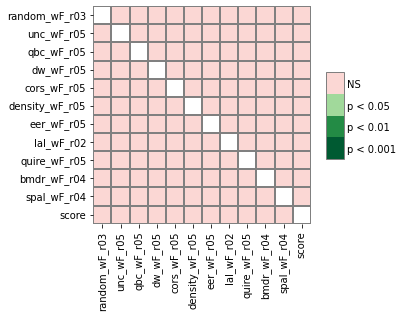

In [42]:
'''for k1 in nemenyi_results.keys():
  for k2 in nemenyi_results[k1].keys():
    pairwise_plotter(nemenyi_results[k1][k2])'''

pairwise_plotter(nemenyi_results['wF']['roc_auc'])

### !!Option 2A: Run Friedman Tests for 2x60 models (average SCORES)

First the results are separated by weight-status. This yields two result-dataframes with 60 columns and 1000 rows. There are ten rows for each dataset and metric, one per generation. Then, ranks are computed line-wise, from 1 through 60. 

Afterwards, ...

In [ ]:
#aggregated_results['wF']
#average_performance.loc[:,'score_wT_r01']

In [20]:
#Friedman Test with post-hoc test
#model_list = ['score', 'random', 'unc', 'qbc', 'dw', 'cors', 'density', 'eer', 'lal', 'quire', 'bmdr', 'spal']
#metrics_list = ['roc_auc', 'brier', 'h-measure', 'pcc', 'balanced_accuracy', 'f1','total_internal_cost','total_internal_cpl','external_cost','external_cpl']
metrics_list = ['roc_auc', 'brier', 'h-measure', 'pcc','balanced_accuracy', 'f1', 'total_internal_cpl','external_cpl']  #'brier', 'h-measure', 'pcc',
#metrics_list = ['roc_auc', 'brier', 'h-measure']
dataset_list = ["bene2", "bene1_nobins","gmsc", "uk", "lendingclub", "hmeq", "pakdd"] #"australian", "german", "thomas", 
#dataset_list = ["bene2", "bene1_nobins","gmsc", "uk", "hmeq", "australian", "german"]
#dataset_list = ["lendingclub", "thomas", "pakdd"]


friedman_results = {'wT':{}, 'wF':{}}
nemenyi_scores = {}
quade_scores = {}

average_ratios = False #this feature does not work correctly, if this is enabled it is unnecessary to loop over ratios. 

for w in ['wT', 'wF']:
  friedman_results[w] = {}
  
  for r in ["r01","r02","r03","r04","r05"]:
    friedman_statistics = pd.DataFrame(columns=['statistic', 'pvalue'], index=metrics_list)

    for s in metrics_list:
      metric_values = []

      for d in dataset_list:
        row_values = []
        if average_ratios:
          columns = model_list
        else:
          columns = []


        for m in model_list:
          if average_ratios:
            row_values.append(performance.filter(regex=f'{m}_{w}').loc[performance.index.str.contains(f'{d}_{s}')].mean().mean())
          else:
            row_values.extend(performance.filter(regex=f'{m}_{w}_{r}').loc[performance.index.str.contains(f'{d}_{s}')].mean().tolist())
            columns.append(f'{m}_{w}_{r}')
          #print(np.shape(row_values))
        
        metric_values.append(row_values)

      print('columns:', columns)
      #invert sign of measurements for metrics where more is better – needed because friedmanchisquare() uses scipy.stats.rankdata(), which ranks in ascending fashion (low value -> low rank)
      if s not in ['brier','total_internal_cost','total_internal_cpl','external_cost','external_cpl']:
        metric_values = np.array(metric_values) * -1
      print(pd.DataFrame(metric_values, columns = columns, index = dataset_list))
      print('\n\n\n------------------------\nMETRIC', s)

      #statistic, pvalue,statistic_uncorr, p_uncorr,ranking,ranking_avg, rank_cmp = friedman_test(*np.transpose(metric_values))
      statistic, pvalue, ranking, ranking_avg, rank_cmp = friedmanchisquare2(*np.transpose(metric_values))


      #print('\n-------------------------------\nscipy Friedman',scipy.stats.friedmanchisquare(*metric_values),'\n-------------------------------\n')
      #print('\n-------------------------------\nPingouin',pg.friedman(pd.DataFrame(metric_values).T),'\n-------------------------------\n')
      
      print('\n-------------------------------\nscipy Friedman MODDED\n-------------------------------\n')
      for pr in [statistic, pvalue, ranking_avg, rank_cmp]: #, ranking,ranking_avg, rank_cmp]:
        print(pr)
      #print('\n-------------------------------\nscikit posthoc quade',sp.posthoc_quade(metric_values),'\n-------------------------------\n')
      print('\n-------------------------------\nCustom STAC\n-------------------------------\n')
      print(friedman_test(*np.transpose(metric_values)))

      temp = {'statistic':statistic, 'pvalue':pvalue}
      friedman_statistics.loc[f'{s}'] = temp



      # POST HOC TEST HOLM
      ranks = {key: rank_cmp[i] for i, key in enumerate(columns)} 
      print('ranks:',ranks)
      print('ranking_avg', ranking_avg)
      print(pd.DataFrame(np.transpose(list(ranks.values())), index = ranks.keys()).iloc[:,0])
      min_rank = pd.DataFrame(np.transpose(list(ranks.values())), index = ranks.keys()).iloc[:,0].argmin()
      
      comparisons, z_values, p_values, adj_p_values = holm_test(ranks, control=columns[min_rank])
      adj_p_values = np.asarray(adj_p_values)
      holm_scores = pd.DataFrame({"p": adj_p_values, "sig": adj_p_values < 0.05}, index=comparisons)
      print(holm_scores)

      '''comparisons, z_values, p_values, adj_p_values = finner_test(ranks, control=columns[min_rank])
      adj_p_values = np.asarray(adj_p_values)
      finner_scores = pd.DataFrame({"p": adj_p_values, "sig": adj_p_values < 0.05}, index=comparisons)
      print(finner_scores)  '''    

      #nemenyi_scores[s] = generate_scores(sp.posthoc_nemenyi_friedman, {}, metric_values, columns)
      #quade_scores[s] = generate_scores(sp.posthoc_quade, {}, metric_values, columns)


    print(np.shape(metric_values))
    print(f'Friedman results for {w}\n',friedman_statistics,'\n\n')
    friedman_results[w][r] = friedman_statistics

'''for key in nemenyi_scores.keys():
  pairwise_plotter(nemenyi_scores[key])'''


Die letzten 5000 Zeilen der Streamingausgabe wurden abgeschnitten.
              score_wT_r02  random_wT_r02  unc_wT_r02  qbc_wT_r02  dw_wT_r02  \
bene2             0.476460       0.524042    0.554553    0.530105   0.520716   
bene1_nobins      0.498741       0.525300    0.537276    0.533710   0.527575   
gmsc              0.567404       0.741020    0.922282    0.956292   0.898762   
uk                0.746770       0.817935    0.902878    0.874459   0.908701   
lendingclub       0.752297       0.771119    0.789691    0.757769   0.789607   
hmeq              0.548308       0.629765    0.681423    0.677985   0.621494   
pakdd             0.668706       0.689959    0.700932    0.689965   0.697321   

              cors_wT_r02  density_wT_r02  eer_wT_r02  lal_wT_r02  \
bene2            0.525654        0.533586    0.557876    0.555714   
bene1_nobins     0.521078        0.520810    0.541701    0.533779   
gmsc             0.809120        0.628677    0.940229    0.851241   
uk              

'for key in nemenyi_scores.keys():\n  pairwise_plotter(nemenyi_scores[key])'

In [21]:
 performance.filter(regex=f'{w}_{r}').columns

Index(['bmdr_wF_r05', 'cors_wF_r05', 'density_wF_r05', 'dw_wF_r05',
       'eer_wF_r05', 'lal_wF_r05', 'qbc_wF_r05', 'quire_wF_r05',
       'random_wF_r05', 'score_wF_r05', 'spal_wF_r05', 'unc_wF_r05'],
      dtype='object')

In [22]:
pd.DataFrame(np.transpose(list(ranks.values())), index = ranks.keys())

,0
score_wF_r05,2.668498
random_wF_r05,3.780372
unc_wF_r05,3.520934
qbc_wF_r05,3.261497
dw_wF_r05,3.854496
cors_wF_r05,3.632122
density_wF_r05,3.039122
eer_wF_r05,3.150310
lal_wF_r05,4.521621
quire_wF_r05,2.446123


In [23]:
ranks

{'bmdr_wF_r05': 2.816747403312185,
 'cors_wF_r05': 3.632121651639396,
 'density_wF_r05': 3.0391221983105146,
 'dw_wF_r05': 3.8544964466377265,
 'eer_wF_r05': 3.15030959580968,
 'lal_wF_r05': 4.521620831632717,
 'qbc_wF_r05': 3.261496993308845,
 'quire_wF_r05': 2.446122744981634,
 'random_wF_r05': 3.780371514971616,
 'score_wF_r05': 2.6684975399799646,
 'spal_wF_r05': 3.780371514971616,
 'unc_wF_r05': 3.5209342541402306}

In [24]:
friedman_results

{'wF': {'r01':                     statistic    pvalue
  roc_auc             11.725275  0.384644
  brier               21.263736  0.030739
  h-measure            5.241758  0.918895
  pcc                  7.263736  0.777341
  balanced_accuracy   11.021978  0.441424
  f1                   9.461538   0.57937
  total_internal_cpl  40.538462  0.000029
  external_cpl        11.021978  0.441424,
  'r02':                     statistic    pvalue
  roc_auc              7.967033  0.716254
  brier               21.857143  0.025504
  h-measure            6.956044  0.802632
  pcc                  8.868132  0.634063
  balanced_accuracy    9.725275  0.555255
  f1                   5.285714  0.916544
  total_internal_cpl  43.175824   0.00001
  external_cpl         9.725275  0.555255,
  'r03':                     statistic    pvalue
  roc_auc              6.802198  0.814868
  brier               19.769231  0.048608
  h-measure            4.296703   0.96042
  pcc                  9.527473  0.573323
  bal

#------------------- RESTE

In [ ]:
'''# ALT: EVERY PARAMETER COMBINATION AS OWN CLASSIFER
#model_list = ['oracle','score', 'random', 'unc', 'qbc', 'dw', 'cors', 'density', 'eer', 'lal', 'quire', 'bmdr', 'spal']
model_list = ['score', 'random', 'unc', 'qbc', 'dw', 'cors', 'density', 'eer', 'lal', 'quire', 'bmdr', 'spal']
metrics_list = ['roc_auc', 'brier', 'h-measure', 'pcc', 'balanced_accuracy', 'f1']
cost_metrics = ['total_internal_cost','total_internal_cpl','external_cost','external_cpl']
metrics_list_full = ['roc_auc', 'brier', 'h-measure', 'pcc', 'balanced_accuracy', 'f1','total_internal_cost','total_internal_cpl','external_cost','external_cpl']

# built list of column names
c_names = model_list
#for i in 
column_names = []
index_names = []

for m in model_list:
  for r in ["r01","r02","r03","r04","r05"]:
      column_names.append(f'{m}_{r}')

for d in dataset_list:
  for s in metrics_list_full:
    for g in range(10):
      index_names.append(f'{d}_{s}_g{g+1}')

results_template2 = pd.DataFrame(columns=column_names, index=index_names)
results_template2'''

In [ ]:
'''metrics_list_full = ['roc_auc', 'brier', 'h-measure', 'pcc', 'balanced_accuracy', 'f1','total_internal_cost','total_internal_cpl','external_cost','external_cpl']
dataset_list = ["bene2", "bene1_nobins","gmsc", "uk", "lendingclub", "hmeq", "australian", "german", "thomas", "pakdd"]

aggregated_results = {}
aggregated_ranks = {}

for w in ['wT', 'wF']:
  friedman_statistics = pd.DataFrame(columns=['statistic', 'pvalue'], index=metrics_list_full)
  average_performance2 = copy.deepcopy(results_template2)

  for s in metrics_list_full:
    for d in dataset_list:
      for m in model_list:
        for r in ["r01","r02","r03","r04","r05"]:
          #element-wise filling of performance dataframe >> very slow!
          #average_performance2.at[f'{d}_{s}_g{g+1}', f'{m}_{r}'] = average_performance.filter(regex=f'{m}_{w}_{r}').loc[average_performance.index.str.contains(f'{d}_{s}_g{g+1}')]
          average_performance2.loc[:, f'{m}_{r}'] = average_performance.loc[:,f'{m}_{w}_{r}']
          #average_performance2.filter(regex=f'{m}_{r}') = average_performance.filter(regex=f'{m}_{w}_{r}')
  
  average_ranks = average_performance2.rank(ascending=False, axis="columns")
  average_ranks.loc[average_ranks.index.str.contains('brier|cost|cpl')] = average_performance2.loc[average_performance2.index.str.contains('brier|cost|cpl')].rank(ascending=True, axis="columns")

  aggregated_results[w] = average_performance2
  aggregated_ranks[w] = average_ranks

'''

In [ ]:
#Friedman Test with results seperated by weights (averaged over ratios)

metrics_list_full = ['roc_auc', 'brier', 'h-measure', 'pcc', 'balanced_accuracy', 'f1','total_internal_cost','total_internal_cpl','external_cost','external_cpl']
metrics_listle = ['roc_auc', 'brier', 'h-measure']
dataset_list = ["bene2", "bene1_nobins","gmsc", "uk", "lendingclub", "hmeq", "australian", "german", "thomas", "pakdd"]


friedman_results = {'wT':{}, 'wF':{}}
nemenyi_scores = {}

average_ratios = False

for w in ['wT']:
  friedman_statistics = pd.DataFrame(columns=['statistic', 'pvalue'], index=metrics_list_full)

  for s in metrics_list_full:
    metric_values = []

    for d in dataset_list:
      row_values = []

      for m in model_list:
        if average_ratios:
          row_values.append(average_performance.filter(regex=f'{m}_{w}').loc[average_performance.index.str.contains(f'{d}_{s}')].mean().mean())
          columns = model_list
        else:
          row_values.extend(average_performance.filter(regex=f'{m}_{w}_r04').loc[average_performance.index.str.contains(f'{d}_{s}')].mean().tolist())
          columns = average_performance.filter(regex=f'{w}_r04').columns
        #print(np.shape(row_values))
      
      metric_values.append(row_values)
    '''for i in metric_values:
      print(i)'''
    
    #invert sign of measurements for metrics where more is better
    if s not in ['brier','total_internal_cost','total_internal_cpl','external_cost','external_cpl']:
      metric_values = np.array(metric_values) * -1

    print('\n\n\n------------------------\nMETRIC', s)

    #statistic2, pvalue2,statistic_uncorr2, p_uncorr2,ranking2,ranking_avg2, rank_cmp2 = friedman_test(*np.transpose(metric_values))
    statistic, pvalue, ranking,ranking_avg, rank_cmp = friedmanchisquare2(*np.transpose(metric_values))
    
    #print(np.shape(metric_values))
    #print('rankings shape (scipy vs. stac):',np.shape(ranking), np.shape(ranking2))
    #print('rank_cmp shape (scipy vs. stac):',np.shape(rank_cmp), np.shape(rank_cmp2))
    #print(pd.DataFrame(metric_values, index=dataset_list, columns=columns))
    #print(np.transpose(metric_values))
    #print(pd.DataFrame(metric_values).T)
    #statistic, pvalue, ranking, rank_cmp = friedman_test(*metric_values)

    #print('\n-------------------------------\nscipy Friedman',scipy.stats.friedmanchisquare(*metric_values),'\n-------------------------------\n')
    #print('\n-------------------------------\nPingouin',pg.friedman(pd.DataFrame(metric_values).T),'\n-------------------------------\n')
    
    print('\n-------------------------------\nscipy Friedman MODDED\n-------------------------------\n')
    for pr in [statistic, pvalue]: #, ranking,ranking_avg, rank_cmp]:
      print(pr)
    #print('\n-------------------------------\nscikit posthoc quade',sp.posthoc_quade(metric_values),'\n-------------------------------\n')
    print('\n-------------------------------\nCustom STAC\n-------------------------------\n')
    #for pr in [ statistic2, pvalue2, statistic_uncorr2, p_uncorr2]: #ranking2, ranking_avg2, rank_cmp2,
    #  print(pr)

    temp = {'statistic':statistic, 'pvalue':pvalue}
    friedman_statistics.loc[f'{s}'] = temp

    # POST HOC TEST HOLM
    ranks = {key: rank_cmp[i] for i, key in enumerate(model_list)} 
    #print(ranks)
    comparisons, z_values, p_values, adj_p_values = holm_test(ranks, control="score")
    adj_p_values = np.asarray(adj_p_values)
    holm_scores = pd.DataFrame({"p": adj_p_values, "sig": adj_p_values < 0.05}, index=comparisons)
    print(holm_scores)

    nemenyi_scores[s] = generate_scores(sp.posthoc_nemenyi_friedman, {}, metric_values, columns)


  print(np.shape(metric_values))
  print(f'Friedman results for {w} (averaged over ratios)\n',friedman_statistics,'\n\n')
  friedman_results[w] = friedman_statistics

'''for key in nemenyi_scores.keys():
  plot(nemenyi_scores[key])'''


In [ ]:
dick = {'score': 3.66825661007747, 'random': 3.7962934900103655, 'unc': 3.6298455460976013, 'qbc': 3.8090971780036553, 'dw': 3.713069518053983, 'cors': 5.825678036946767, 'density': 4.366057605711753, 'eer': 3.0728851183895034, 'lal': 2.1510195828726526, 'quire': 2.9448482384566077, 'bmdr': 6.171377612765586, 'spal': 4.276431789758726}
pos = pd.DataFrame(np.transpose(list(dick.values())), index = dick.keys()).iloc[:,0].argmin()

model_list[pos]

'lal'

# TESTRAMPE

In [ ]:
average_performance.filter(regex=f'{m}_{w}').loc[average_performance.index.str.contains(f'bene2_{s}')]

,spal_wT_r01,spal_wT_r02,spal_wT_r03,spal_wT_r04,spal_wT_r05
bene2_h-measure_g1,0.23,0.247669,0.25156,0.24943,0.251056
bene2_h-measure_g2,0.239093,0.259134,0.261244,0.261257,0.260056
bene2_h-measure_g3,0.257821,0.267587,0.266115,0.267565,0.265583
bene2_h-measure_g4,0.256469,0.266007,0.268314,0.269544,0.268061
bene2_h-measure_g5,0.256978,0.266638,0.272996,0.274614,0.272621
bene2_h-measure_g6,0.263638,0.267299,0.272205,0.271809,0.272366
bene2_h-measure_g7,0.26389,0.266464,0.274262,0.27171,0.271558
bene2_h-measure_g8,0.26751,0.270698,0.274276,0.273527,0.271571
bene2_h-measure_g9,0.263656,0.270666,0.271902,0.274109,0.271773
bene2_h-measure_g10,0.263931,0.268014,0.269957,0.270833,0.269942


In [ ]:
friedman_results

{'wF':                       statistic    pvalue
 roc_auc               47.439782  0.860027
 brier                185.941838       0.0
 h-measure             55.008019  0.623372
 pcc                   40.207361  0.970927
 balanced_accuracy     31.471082  0.998762
 f1                    31.020723     0.999
 total_internal_cost  427.174768       0.0
 total_internal_cpl   429.185027       0.0
 external_cost         31.868151  0.998512
 external_cpl          31.886034    0.9985,
 'wT':                       statistic    pvalue
 roc_auc              196.176262       0.0
 brier                 242.77556       0.0
 h-measure            215.412527       0.0
 pcc                   85.283136  0.014213
 balanced_accuracy    213.942073       0.0
 f1                   192.748897       0.0
 total_internal_cost  399.793802       0.0
 total_internal_cpl   401.773896       0.0
 external_cost         213.40631       0.0
 external_cpl         213.531335       0.0}

In [ ]:
len(friedman_results)

2

In [ ]:
test = [[ 4,6,2,7,8,3,1,5,10,9.],
 [ 4,6,2,7,8,3,1,5,9,10.],
 [ 5,6,2,7,8,3,1,4,9,10.],
 [ 4,6,2,7,8,3,1,5,9,10.],
 [ 4,6,2,7,8,3,1,5,9,10.],
 [ 4,6,2,7,8,3,1,5,10,9.],
 [ 4,6,2,7,8,3,1,5,10,9.],
 [ 5,6,2,7,8,3,1,4,9,10.],
 [ 5,6,2,7,8,3,1,4,9,10.],
 [ 4,6,2,7,8,3,1,5,10,9.],
 [ 5,6,2,7,8,3,1,4,9,10.],
 [ 4,6,2,7,8,3,1,5,10,9.]]

test.mean()

AttributeError: ignored

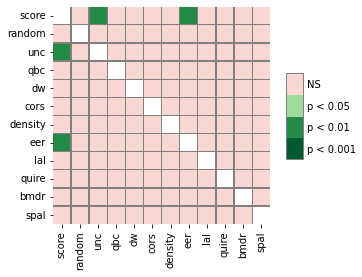

In [ ]:
#print(nemenyi_scores.keys())
#dict_keys(['roc_auc', 'brier', 'h-measure', 'pcc', 'balanced_accuracy', 'f1', 'total_internal_cost', 'total_internal_cpl', 'external_cost', 'external_cpl'])

plot(nemenyi_scores['brier'])

In [ ]:
ranks
test_pd = pd.DataFrame(list(ranks.items()),columns = ['model', 'rank'], index= )
test_pd['rank'].min()
#list(ranks.items())

2.7591947625539084

In [ ]:
import statsmodels.api as sa
#import scikit_posthocs as sp
df1 = sa.datasets.get_rdataset('iris').data
data1 = [df1.loc[ids, 'Sepal.Width'].values for ids in df1.groupby('Species').groups.values()]
df1

,Sepal.Length,Sepal.Width,Petal.Length,Petal.Width,Species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,virginica
146,6.3,2.5,5.0,1.9,virginica
147,6.5,3.0,5.2,2.0,virginica
148,6.2,3.4,5.4,2.3,virginica


In [ ]:
np.shape(data1)

(3, 50)

In [ ]:
ranks.items()

dict_items([('score', 3.6810602980707596), ('random', 3.5786307941244426), ('unc', 3.6810602980707596), ('qbc', 3.5658271061311533), ('dw', 3.2905478142754268), ('cors', 4.29563732174866), ('density', 4.660542429557413), ('eer', 2.7591947625539084), ('lal', 3.8026953340070104), ('quire', 3.9499377459298413), ('bmdr', 3.1112961823693723), ('spal', 3.7770879580204313)])

In [ ]:
ranks = aggregated_ranks['wF']
print(d,s,m,r)
ranks.filter(regex=f'qbc').loc[ranks.index.str.contains(f'roc_auc')]

pakdd external_cpl spal r05


,qbc_r01,qbc_r02,qbc_r03,qbc_r04,qbc_r05
bene2_roc_auc_g1,29.0,15.0,47.0,36.0,45.0
bene2_roc_auc_g2,24.0,20.0,38.0,28.0,26.0
bene2_roc_auc_g3,11.0,9.0,23.0,18.0,24.0
bene2_roc_auc_g4,10.0,13.0,41.0,21.0,12.0
bene2_roc_auc_g5,6.0,8.0,37.0,13.0,14.0
...,...,...,...,...,...
pakdd_roc_auc_g6,18.0,13.0,30.0,56.0,4.0
pakdd_roc_auc_g7,59.0,53.0,13.0,60.0,55.0
pakdd_roc_auc_g8,26.0,57.0,5.0,24.0,55.0
pakdd_roc_auc_g9,36.0,10.0,57.0,27.0,52.0


In [ ]:
#
##### HIGHEST CONFIDENCE; WORST RESULTS
metrics_list_full = ['roc_auc', 'brier', 'h-measure', 'pcc', 'balanced_accuracy', 'f1','total_internal_cost','total_internal_cpl','external_cost','external_cpl']

metrics_listle = ['roc_auc']
dataset_listle = ['bene2', 'bene1_nobins', 'gmsc', 'lendingclub']

friedman_results = {'wT':{}, 'wF':{}}

for w in ['wT', 'wF']:
  friedman_statistics = pd.DataFrame(columns=['statistic', 'pvalue'], index=metrics_list_full)
  ranks = copy.deepcopy(aggregated_ranks[w])
  scores = copy.deepcopy(aggregated_results[w])
  for s in metrics_list_full:
    metric_values = []
    for d in dataset_list:
      row_values = []
      for m in model_list:
        #row_values.extend(scores.filter(regex=f'{m}').loc[scores.index.str.contains(f'{d}_{s}')].mean().tolist()) #60 models, each ratio present
        row_values.append(scores.filter(regex=f'{m}').loc[scores.index.str.contains(f'{d}_{s}')].mean().mean()) #12 models, averaged scores per ratio
        #print(row_values)
      #print(np.shape(row_values))
      metric_values.append(row_values)
    #print(mean_ranks)
    statistic, pvalue = scipy.stats.friedmanchisquare(*metric_values)
    print(scipy.stats.friedmanchisquare(*metric_values))
    #statistic, pvalue = scipy.stats.friedmanchisquare(np.asarray(mean_ranks).ravel())
    temp = {'statistic':statistic, 'pvalue':pvalue}

    friedman_statistics.loc[f'{s}'] = temp
  print(np.shape(metric_values))
  print(f'Friedman results for {w}\n',friedman_statistics,'\n\n')
  friedman_results[w] = friedman_statistics

#friedman_results

NameError: ignored

In [ ]:

d_effe = pd.DataFrame({'white': {0: 10, 1: 8, 2: 7, 3: 9, 4: 7, 5: 4, 6: 5, 7: 6, 8: 5, 9: 10, 10: 4, 11: 7},
                       'red': {0: 7, 1: 5, 2: 8, 3: 6, 4: 5, 5: 7, 6: 9, 7: 6, 8: 4, 9: 6, 10: 7, 11: 3},
                       'rose': {0: 8, 1: 5, 2: 6, 3: 4, 4: 7, 5: 5, 6: 3, 7: 7, 8: 6, 9: 4, 10: 4, 11: 3}})
print('pingouin',pg.friedman(d_effe))
print('\nscipy Friedman',scipy.stats.friedmanchisquare(*d_effe.to_numpy().T),'\n')



pingouin           Source         W  ddof1    Q     p-unc
Friedman  Within  0.083333      2  2.0  0.367879

scipy Friedman FriedmanchisquareResult(statistic=1.9999999999999893, pvalue=0.3678794411714444) 



In [ ]:
d_effe

,white,red,rose
0,10,7,8
1,8,5,5
2,7,8,6
3,9,6,4
4,7,5,7
5,4,7,5
6,5,9,3
7,6,6,7
8,5,4,6
9,10,6,4


In [ ]:
scores.filter(regex=f'{m}').loc[scores.index.str.contains(f'{d}_{s}')].mean()

spal_r01    0.637493
spal_r02    0.638356
spal_r03    0.639836
spal_r04    0.636407
spal_r05    0.639761
dtype: float64

In [ ]:
'''
friedman_results = {'wT':{}, 'wF':{}}

for w in ['wT', 'wF']:
  friedman_statistics = pd.DataFrame(columns=['statistic', 'pvalue'], index=metrics_list_full)
  for s in metrics_list_full:
    mean_ranks = []
    for d in dataset_list:
      row_ranks = []
      for m in model_list:
        #print(m, d)
        #print(average_ranks.filter(regex=f'{m}_wF').loc[average_ranks.filter(regex=f'{m}_wF').index.str.contains(f'{d}_{s}')].mean(axis=1).mean())
        row_ranks.append(average_ranks.filter(regex=f'{m}_{w}').loc[average_ranks.filter(regex=f'{m}_{w}').index.str.contains(f'{d}_{s}')].mean(axis=1).mean())
      #print(np.shape(row_ranks))
      #print(row_ranks)
      
      mean_ranks.append(row_ranks)
    #print(np.shape(mean_ranks))

    statistic, pvalue = scipy.stats.friedmanchisquare(*mean_ranks)
    #statistic, pvalue = scipy.stats.friedmanchisquare(np.asarray(mean_ranks).ravel())
    temp = {'statistic':statistic, 'pvalue':pvalue}

    friedman_statistics.loc[f'{s}'] = temp
  print(f'Friedman results for {w} (averaged over ratios)\n',friedman_statistics,'\n\n')
  friedman_results[w] = friedman_statistics

#friedman_results'''

In [ ]:
print(average_performance.filter(regex=f'{m}_{w}').loc[average_performance.filter(regex=f'{m}_{w}').index.str.contains(f'{d}_{s}')].mean(axis=1).mean())
print(average_performance.filter(regex=f'{m}_{w}').loc[average_performance.filter(regex=f'{m}_{w}').index.str.contains(f'{d}_{s}')].mean().mean())

0.6383703003757379
0.638370300375738


## Perform post-hoc tests

## HALDE: Build averages & Ranks

### Option A

Different Dataframes for different weight and ratio specs, all grouped in a dictionary

In [ ]:
#rounds_list = ['0','1','2','3','4','average']
metrics_list = ['roc_auc', 'brier', 'h-measure', 'pcc', 'balanced_accuracy', 'f1']
#model_list = ['oracle', 'score', 'random', 'unc', 'qbc', 'dw', 'cors', 'density', 'eer', 'lal', 'quire', 'bmdr', 'spal']
model_list = ['score', 'random', 'unc', 'qbc', 'dw', 'cors', 'density', 'eer', 'lal', 'quire', 'bmdr', 'spal']

# built list of columns names
c_names = model_list
#for i in 
index_names = []

for d in dataset_list:
  #for s in metrics_list:
    #for r in ["r01","r02","r03","r04","r05"]:
  for g in range(10):

    #c_names.append(f'{d}_{r}_{s}')
    #index_names.append(f'{d}_{s}_{r}')
    #index_names.append(f'{d}_{s}_g{g}')
    index_names.append(f'{d}_g{g+1}')

performance = pd.DataFrame(columns=c_names, index=index_names)
performance

,score,random,unc,qbc,dw,cors,density,eer,lal,quire,bmdr,spal
bene2_g1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
bene2_g2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
bene2_g3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
bene2_g4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
bene2_g5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
pakdd_g6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
pakdd_g7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
pakdd_g8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
pakdd_g9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# fill in values from results data, just for ONE (the last) generation
performance_dict={'wT': {}, 'wF': {}}
rank_dict={'wT': {}, 'wF': {}}

for w in ['wT', 'wF']:
  #for g in range(11):
  for r in ["r01","r02","r03","r04","r05"]:
    performance_dict[w][r] = {}
    rank_dict[w][r] = {}
    for s in metrics_list:
      average_performance = copy.deepcopy(performance)

      for d in dataset_list:

        #for r in ["r01","r02","r03","r04","r05"]:
        for g in range(10):
          row_results = {}

          for m in model_list:
            row_results[m] = results_dict[w][d][r][m]['average'][s][g+1] # each row represents the average over 5 folds

          #average_performance.loc[f'{d}_{s}_{r}'] = row_results
          average_performance.loc[f'{d}_g{g+1}'] = row_results
      #print(average_performance)

      if s == 'brier':
        average_ranks = average_performance.rank(ascending=True, axis="columns")
      else:
        average_ranks = average_performance.rank(ascending=False, axis="columns")

      performance_dict[w][r][s] = average_performance
      rank_dict[w][r][s] = average_ranks


In [ ]:
rank_dict['wF']['r03']['h-measure']

,score,random,unc,qbc,dw,cors,density,eer,lal,quire,bmdr,spal
bene2_g1,2.0,8.0,11.0,6.0,4.0,5.0,10.0,9.0,12.0,1.0,7.0,3.0
bene2_g2,3.0,9.0,12.0,5.0,4.0,6.0,7.0,11.0,10.0,1.0,8.0,2.0
bene2_g3,6.0,9.0,11.0,7.0,5.0,8.0,3.0,12.0,10.0,1.0,4.0,2.0
bene2_g4,8.0,9.0,11.0,3.0,4.0,7.0,5.0,12.0,10.0,1.0,6.0,2.0
bene2_g5,7.0,3.0,12.0,8.0,6.0,9.0,5.0,11.0,10.0,1.0,4.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...
pakdd_g6,7.0,2.0,11.0,9.0,8.0,3.0,12.0,5.0,10.0,4.0,6.0,1.0
pakdd_g7,8.0,5.0,12.0,4.0,6.0,3.0,9.0,7.0,10.0,1.0,11.0,2.0
pakdd_g8,9.0,7.0,11.0,2.0,6.0,4.0,10.0,8.0,5.0,1.0,12.0,3.0
pakdd_g9,7.0,4.0,6.0,10.0,3.0,1.0,8.0,12.0,2.0,5.0,9.0,11.0


In [ ]:
results_dict['wF']['bene2']['r03']['quire']['average']

,generation,n_accepts,n_rejects,bad_ratio_accepts,bad_ratio_rejects,n_score_accepts,n_AL_selects,bad_ratio_score_accepts,bad_ratio_AL_selects,roc_auc,brier,h-measure,average_precision,balanced_accuracy,pcc,precision,recall,f1,fpr,fnr,tn,fp,fn,tp
0,0.0,NaN,NaN,0.29160,0.30028,NaN,NaN,NaN,NaN,0.758830,0.177684,0.234831,0.540208,0.684491,0.578710,0.434962,0.840068,0.571969,0.471086,0.159932,532.4,474.2,69.0,362.4
1,1.0,711.4,288.6,0.25778,0.39312,148.4,63.0,0.09294,0.36990,0.770609,0.173272,0.254049,0.557257,0.696149,0.621221,0.455843,0.809937,0.582079,0.417639,0.190063,586.2,420.4,82.0,349.4
2,2.0,942.2,557.8,0.23504,0.40488,310.4,131.8,0.08070,0.37470,0.775274,0.171427,0.261085,0.559614,0.702401,0.650029,0.470410,0.784887,0.587673,0.380085,0.215113,624.0,382.6,92.8,338.6
3,3.0,1191.6,808.4,0.22382,0.40928,485.2,206.4,0.08304,0.38498,0.779302,0.170198,0.266388,0.563766,0.713330,0.678238,0.486877,0.779330,0.598906,0.352669,0.220670,651.6,355.0,95.2,336.2
4,4.0,1448.2,1051.8,0.21514,0.41436,665.0,283.2,0.08410,0.38424,0.779095,0.170335,0.267804,0.561314,0.713058,0.693951,0.496148,0.754747,0.598639,0.328631,0.245253,675.8,330.8,105.8,325.6
5,5.0,1722.8,1277.2,0.20796,0.42274,857.6,365.2,0.08470,0.38092,0.782227,0.169640,0.271553,0.565132,0.713527,0.699135,0.499467,0.748729,0.599131,0.321674,0.251271,682.8,323.8,108.4,323.0
6,6.0,1993.8,1506.2,0.20498,0.42430,1047.6,446.2,0.08702,0.38318,0.782791,0.169452,0.271322,0.565377,0.716306,0.704838,0.503225,0.750116,0.602298,0.317504,0.249884,687.0,319.6,107.8,323.6
7,7.0,2262.8,1737.2,0.20088,0.42834,1236.2,526.6,0.08740,0.38000,0.783235,0.169560,0.272992,0.567615,0.711702,0.705551,0.503675,0.732961,0.597013,0.309557,0.267039,695.0,311.6,115.2,316.2
8,8.0,2540.6,1959.4,0.19746,0.43230,1430.8,609.8,0.08620,0.38040,0.783625,0.169464,0.272897,0.568438,0.712364,0.707490,0.505102,0.732495,0.597779,0.307768,0.267505,696.8,309.8,115.4,316.0
9,9.0,2829.8,2170.2,0.19594,0.43542,1633.6,696.2,0.08622,0.38382,0.783195,0.169520,0.271403,0.568710,0.712393,0.707252,0.504954,0.732953,0.597850,0.308167,0.267047,696.4,310.2,115.2,316.2


In [ ]:
#GRAND TOTAL MEAN FOR ONE SPECIFIC GENERATION
#rank_dict['wF']['r03']['roc_auc'].loc[rank_dict['wF']['r03']['roc_auc'].index.str.contains('bene2')].mean()
rank_dict['wF']['r03']['roc_auc']
#rank_dict['wF']['r03']['roc_auc'].mean()

,score,random,unc,qbc,dw,cors,density,eer,lal,quire,bmdr,spal
bene2_g1,2.0,9.0,11.0,8.0,3.0,5.0,7.0,10.0,12.0,1.0,6.0,4.0
bene2_g2,3.0,9.0,12.0,8.0,4.0,7.0,5.0,11.0,10.0,1.0,6.0,2.0
bene2_g3,7.0,9.0,11.0,5.0,3.0,8.0,4.0,12.0,10.0,1.0,6.0,2.0
bene2_g4,4.0,5.0,11.0,9.0,3.0,6.0,7.0,12.0,10.0,2.0,8.0,1.0
bene2_g5,4.0,3.0,11.0,6.0,7.0,8.0,9.0,12.0,10.0,2.0,5.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
pakdd_g6,10.0,2.0,12.0,9.0,6.0,4.0,11.0,7.0,8.0,3.0,5.0,1.0
pakdd_g7,11.0,6.0,12.0,4.0,5.0,3.0,9.0,8.0,10.0,1.0,7.0,2.0
pakdd_g8,9.0,6.0,10.0,2.0,4.0,7.0,12.0,8.0,5.0,3.0,11.0,1.0
pakdd_g9,7.0,4.0,6.0,10.0,1.0,2.0,9.0,12.0,3.0,5.0,8.0,11.0


### Option B

One large dataframe that contains all results, with all combinations of dataset, metric, weight-flag, ratio, generation as indexed rows.

Enables to aggregate over all combinations as well as get specific combinations for testing (via regex-supported index-filtering of the dataframe).

In [ ]:
#rounds_list = ['0','1','2','3','4','average']
metrics_list = ['roc_auc', 'brier', 'h-measure', 'pcc', 'balanced_accuracy', 'f1']
model_list = ['score', 'random', 'unc', 'qbc', 'dw', 'cors', 'density', 'eer', 'lal', 'quire', 'bmdr', 'spal']

# built list of columns names
c_names = ['score', 'random', 'unc', 'qbc', 'dw', 'cors', 'density', 'eer', 'lal', 'quire', 'bmdr', 'spal']
c_names = model_list
#for i in 
index_names = []

for d in dataset_list:
  for s in metrics_list:
    for w in weights_list:
      for r in ["r01","r02","r03","r04","r05"]:
        for g in range(10):

          #c_names.append(f'{d}_{r}_{s}')
          #index_names.append(f'{d}_{s}_{r}')
          #index_names.append(f'{d}_{s}_g{g}')
          index_names.append(f'{d}_{s}_{w}_{r}_g{g+1}')

performance = pd.DataFrame(columns=c_names, index=index_names)
performance

,score,random,unc,qbc,dw,cors,density,eer,lal,quire,bmdr,spal
bene2_roc_auc_wF_r01_g1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
bene2_roc_auc_wF_r01_g2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
bene2_roc_auc_wF_r01_g3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
bene2_roc_auc_wF_r01_g4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
bene2_roc_auc_wF_r01_g5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
pakdd_f1_wT_r05_g6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
pakdd_f1_wT_r05_g7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
pakdd_f1_wT_r05_g8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
pakdd_f1_wT_r05_g9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# fill in values from results data, just for ONE (the last) generation
#performance_dict={}
#rank_dict={}
average_ranks = copy.deepcopy(performance)
average_performance = copy.deepcopy(performance)

for w in ['wT', 'wF']:
  for r in ["r01","r02","r03","r04","r05"]:
    for s in metrics_list:
      for d in dataset_list:
        for g in range(10):
          row_results = {}

          for m in model_list:
            row_results[m] = results_dict[w][d][r][m]['average'][s][g+1] # each row represents the average over 5 folds

          average_performance.loc[f'{d}_{s}_{w}_{r}_g{g+1}'] = row_results

average_ranks.loc[average_ranks.index.str.contains('brier')] = average_performance.loc[average_performance.index.str.contains('brier')].rank(ascending=True, axis="columns")
average_ranks.loc[~average_ranks.index.str.contains('brier')] = average_performance.loc[~average_performance.index.str.contains('brier')].rank(ascending=True, axis="columns")

average_performance

,score,random,unc,qbc,dw,cors,density,eer,lal,quire,bmdr,spal
bene2_roc_auc_wF_r01_g1,0.770134,0.767747,0.767798,0.767436,0.768474,0.768265,0.769048,0.767729,0.767508,0.769937,0.768116,0.769222
bene2_roc_auc_wF_r01_g2,0.773295,0.771066,0.770211,0.772309,0.772434,0.772245,0.772771,0.772385,0.770868,0.774691,0.772747,0.773091
bene2_roc_auc_wF_r01_g3,0.774968,0.775039,0.773135,0.777311,0.775666,0.774135,0.774936,0.776856,0.773511,0.778368,0.77666,0.777249
bene2_roc_auc_wF_r01_g4,0.776541,0.777255,0.774573,0.778015,0.777304,0.776146,0.77573,0.777848,0.77541,0.778291,0.777317,0.77742
bene2_roc_auc_wF_r01_g5,0.779402,0.780345,0.777172,0.781894,0.779583,0.779139,0.778156,0.779353,0.778254,0.780821,0.780599,0.779826
...,...,...,...,...,...,...,...,...,...,...,...,...
pakdd_f1_wT_r05_g6,0.426815,0.421619,0.413351,0.420327,0.416342,0.423094,0.421485,0.411969,0.422075,0.422211,0.422125,0.425894
pakdd_f1_wT_r05_g7,0.429234,0.422002,0.412458,0.421976,0.416674,0.425744,0.423173,0.41489,0.42585,0.425088,0.423419,0.425739
pakdd_f1_wT_r05_g8,0.431305,0.424528,0.413062,0.420026,0.420156,0.426403,0.425895,0.415838,0.421337,0.423356,0.423616,0.42446
pakdd_f1_wT_r05_g9,0.432822,0.424244,0.418666,0.424012,0.417747,0.427803,0.424854,0.418474,0.428951,0.425571,0.424758,0.426446


In [ ]:
average_performance.loc[average_performance.index.str.contains('bene2_roc_auc')].transpose()

,bene2_roc_auc_wF_r01_g1,bene2_roc_auc_wF_r01_g2,bene2_roc_auc_wF_r01_g3,bene2_roc_auc_wF_r01_g4,bene2_roc_auc_wF_r01_g5,bene2_roc_auc_wF_r01_g6,bene2_roc_auc_wF_r01_g7,bene2_roc_auc_wF_r01_g8,bene2_roc_auc_wF_r01_g9,bene2_roc_auc_wF_r01_g10,bene2_roc_auc_wF_r02_g1,bene2_roc_auc_wF_r02_g2,bene2_roc_auc_wF_r02_g3,bene2_roc_auc_wF_r02_g4,bene2_roc_auc_wF_r02_g5,bene2_roc_auc_wF_r02_g6,bene2_roc_auc_wF_r02_g7,bene2_roc_auc_wF_r02_g8,bene2_roc_auc_wF_r02_g9,bene2_roc_auc_wF_r02_g10,bene2_roc_auc_wF_r03_g1,bene2_roc_auc_wF_r03_g2,bene2_roc_auc_wF_r03_g3,bene2_roc_auc_wF_r03_g4,bene2_roc_auc_wF_r03_g5,bene2_roc_auc_wF_r03_g6,bene2_roc_auc_wF_r03_g7,bene2_roc_auc_wF_r03_g8,bene2_roc_auc_wF_r03_g9,bene2_roc_auc_wF_r03_g10,bene2_roc_auc_wF_r04_g1,bene2_roc_auc_wF_r04_g2,bene2_roc_auc_wF_r04_g3,bene2_roc_auc_wF_r04_g4,bene2_roc_auc_wF_r04_g5,bene2_roc_auc_wF_r04_g6,bene2_roc_auc_wF_r04_g7,bene2_roc_auc_wF_r04_g8,bene2_roc_auc_wF_r04_g9,bene2_roc_auc_wF_r04_g10,bene2_roc_auc_wF_r05_g1,bene2_roc_auc_wF_r05_g2,bene2_roc_auc_wF_r05_g3,bene2_roc_auc_wF_r05_g4,bene2_roc_auc_wF_r05_g5,bene2_roc_auc_wF_r05_g6,bene2_roc_auc_wF_r05_g7,bene2_roc_auc_wF_r05_g8,bene2_roc_auc_wF_r05_g9,bene2_roc_auc_wF_r05_g10,bene2_roc_auc_wT_r01_g1,bene2_roc_auc_wT_r01_g2,bene2_roc_auc_wT_r01_g3,bene2_roc_auc_wT_r01_g4,bene2_roc_auc_wT_r01_g5,bene2_roc_auc_wT_r01_g6,bene2_roc_auc_wT_r01_g7,bene2_roc_auc_wT_r01_g8,bene2_roc_auc_wT_r01_g9,bene2_roc_auc_wT_r01_g10,bene2_roc_auc_wT_r02_g1,bene2_roc_auc_wT_r02_g2,bene2_roc_auc_wT_r02_g3,bene2_roc_auc_wT_r02_g4,bene2_roc_auc_wT_r02_g5,bene2_roc_auc_wT_r02_g6,bene2_roc_auc_wT_r02_g7,bene2_roc_auc_wT_r02_g8,bene2_roc_auc_wT_r02_g9,bene2_roc_auc_wT_r02_g10,bene2_roc_auc_wT_r03_g1,bene2_roc_auc_wT_r03_g2,bene2_roc_auc_wT_r03_g3,bene2_roc_auc_wT_r03_g4,bene2_roc_auc_wT_r03_g5,bene2_roc_auc_wT_r03_g6,bene2_roc_auc_wT_r03_g7,bene2_roc_auc_wT_r03_g8,bene2_roc_auc_wT_r03_g9,bene2_roc_auc_wT_r03_g10,bene2_roc_auc_wT_r04_g1,bene2_roc_auc_wT_r04_g2,bene2_roc_auc_wT_r04_g3,bene2_roc_auc_wT_r04_g4,bene2_roc_auc_wT_r04_g5,bene2_roc_auc_wT_r04_g6,bene2_roc_auc_wT_r04_g7,bene2_roc_auc_wT_r04_g8,bene2_roc_auc_wT_r04_g9,bene2_roc_auc_wT_r04_g10,bene2_roc_auc_wT_r05_g1,bene2_roc_auc_wT_r05_g2,bene2_roc_auc_wT_r05_g3,bene2_roc_auc_wT_r05_g4,bene2_roc_auc_wT_r05_g5,bene2_roc_auc_wT_r05_g6,bene2_roc_auc_wT_r05_g7,bene2_roc_auc_wT_r05_g8,bene2_roc_auc_wT_r05_g9,bene2_roc_auc_wT_r05_g10
score,0.770134,0.773295,0.774968,0.776541,0.779402,0.780136,0.780852,0.781493,0.782483,0.78271,0.770134,0.773295,0.774997,0.776572,0.779517,0.780165,0.780887,0.781518,0.782533,0.782734,0.770134,0.773295,0.774968,0.776541,0.779402,0.780136,0.780852,0.781493,0.782483,0.78271,0.770134,0.773295,0.774997,0.776572,0.779517,0.780165,0.780887,0.781518,0.782533,0.782734,0.770082,0.773194,0.774919,0.776527,0.779528,0.780024,0.780822,0.781428,0.78257,0.782603,0.770134,0.773295,0.774968,0.776541,0.779402,0.780136,0.780852,0.781493,0.782483,0.78271,0.770134,0.773295,0.774997,0.776572,0.779517,0.780165,0.780887,0.781518,0.782533,0.782734,0.770134,0.773295,0.774968,0.776541,0.779402,0.780136,0.780852,0.781493,0.782483,0.78271,0.770134,0.773295,0.774997,0.776572,0.779517,0.780165,0.780887,0.781518,0.782533,0.782734,0.770082,0.773194,0.774919,0.776527,0.779528,0.780024,0.780822,0.781428,0.78257,0.782603
random,0.767747,0.771066,0.775039,0.777255,0.780345,0.780668,0.781443,0.781986,0.78246,0.782534,0.765351,0.771131,0.775088,0.77585,0.778946,0.779469,0.779959,0.781748,0.781898,0.781858,0.765912,0.768145,0.772686,0.776291,0.779984,0.780817,0.78126,0.781484,0.78203,0.781587,0.768434,0.772394,0.775547,0.776988,0.780194,0.780252,0.780534,0.781421,0.781008,0.780649,0.766735,0.769033,0.772843,0.775395,0.777919,0.778877,0.780077,0.781296,0.781188,0.781039,0.75766,0.759129,0.759609,0.762208,0.771234,0.772935,0.773732,0.776615,0.777953,0.777536,0.762809,0.769283,0.770805,0.774743,0.777052,0.77975,0.780047,0.780975,0.781298,0.782156,0.765291,0.767009,0.7733,0.777898,0.78197,0.78284,0.783425

In [ ]:
#average_performance.loc[~average_performance.index.str.contains('brier')].rank(ascending=False, axis="columns")

In [ ]:
average_ranks

,score,random,unc,qbc,dw,cors,density,eer,lal,quire,bmdr,spal
bene2_roc_auc_wF_r01_g1,12.0,4.0,5.0,1.0,8.0,7.0,9.0,3.0,2.0,11.0,6.0,10.0
bene2_roc_auc_wF_r01_g2,11.0,3.0,1.0,5.0,7.0,4.0,9.0,6.0,2.0,12.0,8.0,10.0
bene2_roc_auc_wF_r01_g3,5.0,6.0,1.0,11.0,7.0,3.0,4.0,9.0,2.0,12.0,8.0,10.0
bene2_roc_auc_wF_r01_g4,5.0,6.0,1.0,11.0,7.0,4.0,3.0,10.0,2.0,12.0,8.0,9.0
bene2_roc_auc_wF_r01_g5,6.0,9.0,1.0,12.0,7.0,4.0,2.0,5.0,3.0,11.0,10.0,8.0
...,...,...,...,...,...,...,...,...,...,...,...,...
pakdd_f1_wT_r05_g6,12.0,6.0,2.0,4.0,3.0,10.0,5.0,1.0,7.0,9.0,8.0,11.0
pakdd_f1_wT_r05_g7,12.0,5.0,1.0,4.0,3.0,10.0,6.0,2.0,11.0,8.0,7.0,9.0
pakdd_f1_wT_r05_g8,12.0,9.0,1.0,3.0,4.0,11.0,10.0,2.0,5.0,6.0,7.0,8.0
pakdd_f1_wT_r05_g9,12.0,5.0,3.0,4.0,1.0,10.0,7.0,2.0,11.0,8.0,6.0,9.0


In [ ]:
statistics = pd.DataFrame(columns=['statistic', 'pvalue'], index=metrics_list)
metrics_listle = ['roc_auc']
#temp = {}
for m in metrics_list:
  mean_ranks = []
  for d in dataset_list:
    mean_ranks.append(average_ranks.loc[average_ranks.index.str.contains(f'{d}_{m}_wT')].mean())
  #print(f'\n\n\n-------------------------------\n{m}')
  #print(mean_ranks)
  #print(np.shape(mean_ranks))
  statistic, pvalue = scipy.stats.friedmanchisquare(*mean_ranks)
  #statistic, pvalue = scipy.stats.friedmanchisquare(np.asarray(mean_ranks).ravel())
  temp = {'statistic':statistic, 'pvalue':pvalue}

  statistics.loc[f'{m}'] = temp

statistics

,statistic,pvalue
roc_auc,0.52834,0.999961
brier,1.259727,0.998568
h-measure,0.955511,0.999533
pcc,0.468418,0.999977
balanced_accuracy,0.568469,0.999947
f1,1.080547,0.999228


In [ ]:
average_ranks.loc[average_ranks.index.str.contains('bene2_roc_auc')].mean()

In [ ]:
'''for w in ['wT', 'wF']:
  for r in ["r01","r02","r03","r04","r05"]:
    #performance_dict[w][r] = {}
    #rank_dict[w][r] = {}
    for s in metrics_list:
      average_performance = copy.deepcopy(performance)

      for d in dataset_list:

        #for r in ["r01","r02","r03","r04","r05"]:
        for g in range(11):'''

In [ ]:
# https://docs.scipy.org/doc/scipy/reference/stats.html#statistical-tests
# https://scikit-posthocs.readthedocs.io/en/latest/generated/scikit_posthocs.posthoc_quade/
# https://puolival.github.io/multipy/
# https://github.com/CoBiG2/cobig_misc_scripts

## BULLSHIT Performance and Ranks (AVERAGE RANKS)

**Run every combination of weights, ratio as distinct model**

Same as B, but with different shape. The idea is to have not just 12 models as columns, but instead have each combination of main parameters (model-weight-ratio) as one model (columns)

This changes the shape of the results-DF to having 120 (instead of 12) columns and 600 (6000) rows. Same amount of cells naturally.

This means there are more models available when doing the Friedman Test, with ranks from 1-120. Maybe this increases the change to have significant results in the Friedman Test?!

**BUT: Difficult to fill in the data!**

### Option 1A: Run Friedman Test for 2 X 60 models (average RANKS)

RANKS are averaged over generations, separated by weight-choice. Each combination of ratio and weight is kept as a separate model.

In [ ]:
metrics_list_full = ['roc_auc', 'brier', 'h-measure', 'pcc', 'balanced_accuracy', 'f1','total_internal_cost','total_internal_cpl','external_cost','external_cpl']
metrics_listle = ['roc_auc']
dataset_listle = ['bene2', 'bene1_nobins', 'gmsc', 'hmeq']

friedman_results = {'wT':{}, 'wF':{}}

for w in ['wT', 'wF']:
  friedman_statistics = pd.DataFrame(columns=['statistic', 'pvalue'], index=metrics_list_full)
  for m in metrics_list_full:
    mean_ranks = []
    #print(f'\n\n\n-------------------------------\n{m}')

    for d in dataset_list:
      #print(f'\n\n\n-------------------------------\n{d}')

      '''mean_ranks.append(average_ranks.filter(regex=f'{w}').loc[average_ranks.filter(regex=f'{w}').index.str.contains(f'{d}_{m}')].mean())'''
      mean_ranks.append(average_ranks.filter(regex=f'{w}').loc[average_ranks.index.str.contains(f'{d}_{m}')].mean())
      #mean_ranks.append(average_ranks.loc[average_ranks.index.str.contains(f'{d}_{m}')].mean())
      #print(average_ranks.loc[average_ranks.index.str.contains(f'{d}_{m}')].mean())
      #if m == 'roc_auc':
        #print(average_ranks.loc[average_ranks.index.str.contains(f'{d}_{m}')].mean().sort_values().head(10))
        #print('...')
        #print(average_ranks.loc[average_ranks.index.str.contains(f'{d}_{m}')].mean().sort_values().tail(10))
        #print(mean_ranks)
    print(m, d, np.shape(mean_ranks))
    statistic, pvalue = scipy.stats.friedmanchisquare(*mean_ranks)
    #statistic, pvalue = scipy.stats.friedmanchisquare(np.asarray(mean_ranks).ravel())
    temp = {'statistic':statistic, 'pvalue':pvalue}

    friedman_statistics.loc[f'{m}'] = temp

  print(f'Friedman results for {w} (all ratios separate)\n',friedman_statistics,'\n\n')
  friedman_results[w] = friedman_statistics

roc_auc pakdd (10, 0)


ZeroDivisionError: ignored

### Option 1B: Run Friedman Tests for 2x12 models (average RANKS)

RANKS are averaged over generations AND ratios!

In [ ]:
friedman_results = {'wT':{}, 'wF':{}}

for w in ['wT', 'wF']:
  friedman_statistics = pd.DataFrame(columns=['statistic', 'pvalue'], index=metrics_list_full)
  for s in metrics_list_full:
    mean_ranks = []
    for d in dataset_list:
      row_ranks = []
      for m in model_list:
        #print(m, d)
        #print(average_ranks.filter(regex=f'{m}_wF').loc[average_ranks.filter(regex=f'{m}_wF').index.str.contains(f'{d}_{s}')].mean(axis=1).mean())
        '''row_ranks.append(average_ranks.filter(regex=f'{m}_{w}').loc[average_ranks.filter(regex=f'{m}_{w}').index.str.contains(f'{d}_{s}')].mean(axis=1).mean())'''
        row_ranks.append(average_ranks.filter(regex=f'{m}_{w}').loc[average_ranks.index.str.contains(f'{d}_{s}')].mean(axis=1).mean())

      #print(np.shape(row_ranks))
      #print(row_ranks)
      
      mean_ranks.append(row_ranks)
    #print(np.shape(mean_ranks))

    statistic, pvalue = scipy.stats.friedmanchisquare(*mean_ranks)
    #statistic, pvalue = scipy.stats.friedmanchisquare(np.asarray(mean_ranks).ravel())
    temp = {'statistic':statistic, 'pvalue':pvalue}

    friedman_statistics.loc[f'{s}'] = temp
  print(f'Friedman results for {w} (averaged over ratios)\n',friedman_statistics,'\n\n')
  friedman_results[w] = friedman_statistics

#friedman_results

Friedman results for wT (averaged over ratios)
                     statistic pvalue
roc_auc                 108.0    0.0
brier                   108.0    0.0
h-measure               108.0    0.0
pcc                     108.0    0.0
balanced_accuracy       108.0    0.0
f1                      108.0    0.0
total_internal_cost     108.0    0.0
total_internal_cpl      108.0    0.0
external_cost           108.0    0.0
external_cpl            108.0    0.0 


Friedman results for wF (averaged over ratios)
                     statistic pvalue
roc_auc                 108.0    0.0
brier                   108.0    0.0
h-measure               108.0    0.0
pcc                     108.0    0.0
balanced_accuracy       108.0    0.0
f1                      108.0    0.0
total_internal_cost     108.0    0.0
total_internal_cpl      108.0    0.0
external_cost           108.0    0.0
external_cpl            108.0    0.0 




In [ ]:
average_ranks.filter(regex='wF').loc[average_ranks.filter(regex='wF').index.str.contains(f'bene1_nobins_roc_auc')].mean()

In [ ]:
np.random.seed(0)
df = pd.DataFrame(np.random.randint(0,10,(100,3),),columns=['var1','var2','var3'])

In [ ]:
f_test = scipy.stats.friedmanchisquare(df['var1'],df['var2'],df['var3'])
f_res = pd.DataFrame({'test':'Friedman','statistic':f_test[0],'pvalue':f_test[1]},index=[0])

In [ ]:
f_res

,test,statistic,pvalue
0,Friedman,0.348066,0.840269
